In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio

import itertools
import pickle
import json

from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from feature_engine.selection import DropDuplicateFeatures, DropCorrelatedFeatures, SmartCorrelatedSelection
from optbinning import BinningProcess, OptimalBinning

from sklearn.feature_selection import SelectFromModel, SelectKBest

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, log_loss, make_scorer

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

import optuna

import warnings
warnings.simplefilter('ignore')    # ignore warnings

(CVXPY) Nov 09 06:28:51 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Nov 09 06:28:51 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


/home/mai/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## 1. Load data

For our analysis, we will use the training dataset located at `./data/train.csv`

This Dataset is the training dataset in a Hackathon organized by Deloitte. The aim is to predict whether a person will be a loan defaulter or not by looking at various attributes like funded amount, location, loan, balance, etc. In reality, banks and finance institutions would create credit scorecards for such tasks and rank their customers by credit score.

In first sections of this notebook, we will focus on feature engineering to extract and prepare our dataset for a classifier algorithm. At the end, we will use the engineered features to fit a classifier.

In [3]:
df = pd.read_csv('./data/train.csv')

df.head()

ID  Loan Amount  Funded Amount  Funded Amount Investor  Term  \
0  65087372        10000          32236             12329.36286    59   
1   1450153         3609          11940             12191.99692    59   
2   1969101        28276           9311             21603.22455    59   
3   6651430        11170           6954             17877.15585    59   
4  14354669        16890          13226             13539.92667    59   

  Batch Enrolled  Interest Rate Grade Sub Grade Employment Duration  \
0     BAT2522922      11.135007     B        C4            MORTGAGE   
1     BAT1586599      12.237563     C        D3                RENT   
2     BAT2136391      12.545884     F        D4            MORTGAGE   
3     BAT2428731      16.731201     C        C3            MORTGAGE   
4     BAT5341619      15.008300     C        D4            MORTGAGE   

   Home Ownership Verification Status Payment Plan               Loan Title  \
0    176346.62670        Not Verified            n       Debt Consolidation   
1     39833.92100     Source Verified            n       Debt consolidation   
2     91506.69105     Source Verified            n       Debt Consolidation   
3    108286.57590     Source Verified            n       Debt consolidation   
4     44234.82545     Source Verified            n  Credit card refinancing   

   Debit to Income  Delinquency - two years  Inquires - six months  \
0        16.284758                        1                      0   
1        15.412409                        0                      0   
2        28.137619                        0                      0   
3        18.043730                        1                      0   
4        17.209886                        1                      3   

   Open Account  Public Record  Revolving Balance  Revolving Utilities  \
0            13              0              24246            74.932551   
1            12              0                812            78.297186   
2            14              0               1843             2.073040   
3             7              0              13819            67.467951   
4            13              1               1544            85.250761   

   Total Accounts Initial List Status  Total Received Interest  \
0               7                   w              2929.646315   
1              13                   f               772.769385   
2              20                   w               863.324396   
3              12                   w               288.173196   
4              22                   w               129.239553   

   Total Received Late Fee   Recoveries  Collection Recovery Fee  \
0                 0.102055     2.498291                 0.793724   
1                 0.036181     2.377215                 0.974821   
2                18.778660     4.316277                 1.020075   
3                 0.044131     0.107020                 0.749971   
4                19.306646  1294.818751                 0.368953   

   Collection 12 months Medical Application Type  Last week Pay  \
0                             0       INDIVIDUAL             49   
1                             0       INDIVIDUAL            109   
2                             0       INDIVIDUAL             66   
3                             0       INDIVIDUAL             39   
4                             0       INDIVIDUAL             18   

   Accounts Delinquent  Total Collection Amount  Total Current Balance  \
0                    0                       31                 311301   
1                    0                       53                 182610   
2                    0                       34                  89801   
3                    0                       40                   9189   
4                    0                      430                 126029   

   Total Revolving Credit Limit  Loan Status  
0                          6619            0  
1                         20885            0  
2      

Brief description of columns:

- `ID`: unique ID of representative
- `Loan Amount`: loan amount applied
- `Funded Amount`: loan amount funded
- `Funded Amount Investor`: loan amount approved by the investors
- `Term`: term of loan (in months)
- `Batch Enrolled`: batch numbers to representatives
- `Interest Rate`: interest rate (%) on loan
- `Grade`: grade by the bank
- `Sub Grade`: sub-grade by the bank
- `Employment Duration`: duration
- `Home Ownership`: Ownership of home
- `Verification Status`: Income verification by the bank
- `Payment Plan`: if any payment plan has started against loan
- `Loan Title`: loan title provided
- `Debit to Income`: ratio of representative's total monthly debt repayment divided by self reported monthly income excluding mortgage
- `Delinquency - two years`: number of 30+ days delinquency in past 2 years
- `Inquiries - six months`: total number of inquiries in last 6 months
- `Open Account`: number of open credit line in representative's credit line
- `Public Records`: number of derogatory public records
- `Revolving Balance`: total credit revolving balance
- `Revolving Utilities`: amount of credit a representative is using relative to Revolving Balance
- `Total Accounts`: total number of credit lines available in representative's credit lines
- `Initial List Status`: unique listing status of the loan - W(Waiting), F(Forwarded)
- `Total Received Interest`: total interest received till date
- `Total Received Late Fee`: total late fee received till date
- `Recoveries`: post charge off gross recovery
- `Collection Recovery Fee`: post charge off collection fee
- `Collection 12 months Medical`: total collections in last 12 months excluding medical collections
- `Application Type`: indicates when the representative is an individual or joint
- `Last week Pay`: indicates how long (in weeks) a representative has paid EMI after batch enrolled
- `Accounts Delinquent`: number of accounts on which the representative is delinquent
- `Total Collection Amount`: total collection amount ever owed
- `Total Current Balance`: total current balance from all accounts
- `Total Revolving Credit Limit`: total revolving credit limit
- `Loan Status`: 1 = Defaulter, 0 = Non-defaulter

First, it seems like the data in `Employment Duration` should have been `Home Ownership`. We are not sure what the data in `Home Ownership` would have been, but one possibility is income. So for now, let's just swap the two column labels.

In [4]:
df[['Home Ownership', 'Employment Duration']] = df[['Employment Duration', 'Home Ownership']]

In [5]:
# let's also convert the column names to lowercase snake case 
col_names_new = [var.lower().replace('- ', '').replace(' ', '_') for var in df.columns]
df.columns = col_names_new

df.head(10)

id  loan_amount  funded_amount  funded_amount_investor  term  \
0  65087372        10000          32236            12329.362860    59   
1   1450153         3609          11940            12191.996920    59   
2   1969101        28276           9311            21603.224550    59   
3   6651430        11170           6954            17877.155850    59   
4  14354669        16890          13226            13539.926670    59   
5  50509046        34631          30203             8635.931613    36   
6  32737431        30844          19773            15777.511830    59   
7  63151650        20744          10609             7645.014802    58   
8   4279662         9299          11238            13429.456610    59   
9   4431034        19232           8962             7004.097481    58   

  batch_enrolled  interest_rate grade sub_grade  employment_duration  \
0     BAT2522922      11.135007     B        C4         176346.62670   
1     BAT1586599      12.237563     C        D3          39833.92100   
2     BAT2136391      12.545884     F        D4          91506.69105   
3     BAT2428731      16.731201     C        C3         108286.57590   
4     BAT5341619      15.008300     C        D4          44234.82545   
5     BAT4694572      17.246986     B        G5          98957.47561   
6     BAT4808022      10.731432     C        C5         102391.82430   
7     BAT2558388      13.993688     A        A5          61723.52014   
8     BAT5341619      11.178457     G        C2          63205.09072   
9     BAT2078974       5.520413     C        B5          42015.46586   

  home_ownership verification_status payment_plan               loan_title  \
0       MORTGAGE        Not Verified            n       Debt Consolidation   
1           RENT     Source Verified            n       Debt consolidation   
2       MORTGAGE     Source Verified            n       Debt Consolidation   
3       MORTGAGE     Source Verified            n       Debt consolidation   
4       MORTGAGE     Source Verified            n  Credit card refinancing   
5           RENT        Not Verified            n  Credit card refinancing   
6           RENT            Verified            n         Home improvement   
7            OWN        Not Verified            n       Debt consolidation   
8       MORTGAGE            Verified            n  Credit card refinancing   
9           RENT     Source Verified            n  Credit card refinancing   

   debit_to_income  delinquency_two_years  inquires_six_months  open_account  \
0        16.284758                      1                    0            13   
1        15.412409                      0                    0            12   
2        28.137619                      0                    0            14   
3        18.043730                      1                    0             7   
4        17.209886                      1                    3            13   
5         7.914333                      3                    2            16   
6        15.083911                      0                    0            11   
7        29.829715                      0                    0            14   
8        26.244710                      0                    0             6   
9        10.048549                      1                    0            11   

   public_record  revolving_balance  revolving_utilities  total_accounts  \
0              0              24246            74.932551               7   
1              0                812            78.297186              13   
2              0               1843             2.073040              20   
3              0              13819            67.467951              12   
4              1               1544            85.250761              22   
5              0               2277            51.564476              20   
6              0              14501            46.808804              37   
7              0              13067            23.936624        

In [6]:
# check the number of rows and columns
df.shape

(67463, 35)

In [7]:
# Displays column names, complete (non-missing) cases per column, and datatype per column.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            67463 non-null  int64  
 1   loan_amount                   67463 non-null  int64  
 2   funded_amount                 67463 non-null  int64  
 3   funded_amount_investor        67463 non-null  float64
 4   term                          67463 non-null  int64  
 5   batch_enrolled                67463 non-null  object 
 6   interest_rate                 67463 non-null  float64
 7   grade                         67463 non-null  object 
 8   sub_grade                     67463 non-null  object 
 9   employment_duration           67463 non-null  float64
 10  home_ownership                67463 non-null  object 
 11  verification_status           67463 non-null  object 
 12  payment_plan                  67463 non-null  object 
 13  l

Our data does not have any missing data.

In [8]:
# get some descriptive statistics
# for categorical features, we will also see the number of unique values
df.describe(include='all').T

count unique                      top   freq  \
id                            67463.0    NaN                      NaN    NaN   
loan_amount                   67463.0    NaN                      NaN    NaN   
funded_amount                 67463.0    NaN                      NaN    NaN   
funded_amount_investor        67463.0    NaN                      NaN    NaN   
term                          67463.0    NaN                      NaN    NaN   
batch_enrolled                  67463     41               BAT3873588   3626   
interest_rate                 67463.0    NaN                      NaN    NaN   
grade                           67463      7                        C  19085   
sub_grade                       67463     35                       B4   4462   
employment_duration           67463.0    NaN                      NaN    NaN   
home_ownership                  67463      3                 MORTGAGE  36351   
verification_status             67463      3          Source Verified  33036   
payment_plan                    67463      1                        n  67463   
loan_title                      67463    109  Credit card refinancing  30728   
debit_to_income               67463.0    NaN                      NaN    NaN   
delinquency_two_years         67463.0    NaN                      NaN    NaN   
inquires_six_months           67463.0    NaN                      NaN    NaN   
open_account                  67463.0    NaN                      NaN    NaN   
public_record                 67463.0    NaN                      NaN    NaN   
revolving_balance             67463.0    NaN                      NaN    NaN   
revolving_utilities           67463.0    NaN                      NaN    NaN   
total_accounts                67463.0    NaN                      NaN    NaN   
initial_list_status             67463      2                        w  36299   
total_received_interest       67463.0    NaN                      NaN    NaN   
total_received_late_fee       67463.0    NaN                      NaN    NaN   
recoveries                    67463.0    NaN                      NaN    NaN   
collection_recovery_fee       67463.0    NaN                      NaN    NaN   
collection_12_months_medical  67463.0    NaN                      NaN    NaN   
application_type                67463      2               INDIVIDUAL  67340   
last_week_pay                 67463.0    NaN                      NaN    NaN   
accounts_delinquent           67463.0    NaN                      NaN    NaN   
total_collection_amount       67463.0    NaN                      NaN    NaN   
total_current_balance         67463.0    NaN                      NaN    NaN   
total_revolving_credit_limit  67463.0    NaN                      NaN    NaN   
loan_status                   67463.0    NaN                      NaN    NaN   

                                         mean              std          min  \
id                            25627607.746498  21091554.023733    1297933.0   
loan_amount                      16848.902776      8367.865726       1014.0   
funded_amount                    15770.599114      8150.992662       1014.0   
funded_amount_investor           14621.799323       6785.34517  1114.590204   
term                                58.173814         3.327441         36.0   
batch_enrolled                            NaN              NaN          NaN   
interest_rate                       11.846258         3.718629     5.320006   
grade                                     NaN              NaN          NaN   
sub_grade                                 NaN              NaN          NaN   
employment_duration              80541.502522     45029.120366  14573.53717   
home_ownership                            NaN              NaN          NaN   
verification_status                       NaN              NaN          NaN   
payment_plan                              NaN              NaN          NaN   
loan_title                                NaN

In [9]:
# let's separate the data into target and features
target = 'loan_status'

y = df[target]
X = df[[col for col in df.columns if col not in [target, 'id']]]

In [10]:
X.shape, y.shape

((67463, 33), (67463,))

## 2. Extract more features from the existing features

Based on the features' description, we can extract some more features from the existing ones.

In [11]:
# Group 1: features related to loan amount, funded, and funded investor amount
# total funded and funded investor
X['funded_sum'] = X['funded_amount'] + X['funded_amount_investor']
# loan amount to funded amount ratio
X['loan_to_funded'] = X['loan_amount'] / X['funded_amount']
# loan amount to funded investor ratio
X['loan_to_funded_investor'] = X['loan_amount'] / X['funded_amount_investor']
# funded to funded investor ratio
X['funded_to_funded_investor'] = X['funded_amount'] / X['funded_amount_investor']

In [12]:
# Group 2: interest rate, debit to income and employment duration
# income to interest rate 
X['employment_to_interest'] = X['employment_duration'] / X['interest_rate']
# interest rate to debit to income
X['interest_to_debit'] = X['interest_rate'] / X['debit_to_income']

In [13]:
# Group 3: delinquencies, public record, open account
# any inquries in last six months
X['any_inquires_six_months'] = (X['inquires_six_months'] > 0).astype(int).astype(object)
# any delinquency last 2 years
X['any_delinquency_two_years'] = (X['delinquency_two_years'] > 0).astype(int).astype(object)
# any collections in last 12 months excluding medical collections
X['any_collection_12_months_medical'] = (X['collection_12_months_medical'] > 0).astype(int).astype(object)
# any public derogatory records
X['any_public_record'] = (X['public_record'] > 0).astype(int).astype(object)

# delinquency per open account
X['deliquencies_per_open_account'] = X['delinquency_two_years'] / X['open_account']
# inquires per open account
X['inquires_per_open_account'] = X['inquires_six_months'] / X['open_account']
# public records per open account
X['records_per_open_account'] = X['public_record'] / X['open_account']

In [14]:
# Group 4: revolving balance and utilities
# revolving balance  * revolving utilities
X['revolving_balance_utilities_prod'] = X['revolving_balance'] * X['revolving_utilities']

In [15]:
# Group 5: open account and total accounts
X['open_account_to_total_account'] = X['open_account'] / X['total_accounts']
X['open_account_total_account_diff'] = X['total_accounts'] - X['open_account']

In [16]:
# Group 6: received interest, late fee, total accounts
X['received_interest_per_account'] = X['total_received_interest'] / X['total_accounts']
X['received_late_fee_per_account'] = X['total_received_late_fee'] / X['total_accounts']

In [17]:
# Group 7: recovereies, collection fee
X['recoveries_collection_fee_total'] = X['recoveries'] + X['collection_recovery_fee']
X['recoveries_collection_fee_prod'] = X['recoveries'] * X['collection_recovery_fee']

In [18]:
# Group 8: last week pay, total amount balance, credit limit
X['collection_amount_per_weekpay'] = X['total_collection_amount'] / X['last_week_pay']
X['collection_amount_weekday_prod'] = X['total_collection_amount'] * X['last_week_pay']
X['current_balance_revolving_credit_limit_total'] = X['total_current_balance'] + X['total_revolving_credit_limit']
X['current_balance_to_revolving_credit_limit'] = X['total_current_balance'] / X['total_revolving_credit_limit']

In [19]:
# Modify some features
# batch number (extract the number part only)
X['batch_enrolled'] = X['batch_enrolled'].apply(lambda x: x[3:]).astype(object)
# term - treat as categorical feature
X['term'] = X['term'].astype(str).astype(object)

In [20]:
X.shape, y.shape

((67463, 57), (67463,))

Now, let's split our data into a train and test set. We will use the train set for the next steps of feature engineering and we will use the result pipeline to transform the test set accordingly.

In [21]:
# first, let's separate our data into a train and test set (just a subset of the data that we are leaving out for validation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(53970, 57) (53970,)
(13493, 57) (13493,)


## 3. Drop constant, quasi-constant, and duplicate variables

Next, let's identify constant and quasi-constant variables in our dataset using a variance threshold. Variables that have lower variance than this threshold will be considered a (quasi)constant variable and will be dropped from the analysis as they will not add any useful information towards whether a person is a defaulter.

We can use `sklearn.feature_selection.VarianceThreshold` to drop features with variance below a certain threshold, but the method is only applicable to numeric variables. If we want to apply the variance threshold method on non-numeric variables, we have to code it ourselves.

In [22]:
class DropQuasiConstantFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, predominant_threshold=0.998):
        self.predominant_threshold = predominant_threshold
        # create an empty list to store quasi-constant features
        self.quasi_constant_features = []
        
    def fit(self, X, y=None):
        for feature in X.columns:
            # find the predominant value (shared by most observations):
            predominant = X[feature].value_counts(normalize=True).sort_values(ascending=False).values[0]
            # evaluate the predominant value frequency: does it exceed the threshold?
            if predominant > self.predominant_threshold:
                # if yes, add the feature to the list
                self.quasi_constant_features.append(feature)

        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed.drop(self.quasi_constant_features, axis=1, inplace=True)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [23]:
drop_quasi_constant = DropQuasiConstantFeatures()
# we use the fit method to get the list of quasi-constant variables
quasi_constant_vars = drop_quasi_constant.fit(X_train).quasi_constant_features

print('Quasi-constant variables:', quasi_constant_vars)

Quasi-constant variables: ['payment_plan', 'application_type', 'accounts_delinquent']


In [24]:
# let's drop these variables
X_train = drop_quasi_constant.transform(X_train)
X_test = drop_quasi_constant.transform(X_test)
# check the number of variables after dropping quasi-constant variables
print(X_train.shape, X_test.shape)

(53970, 54) (13493, 54)


Let's also check if our dataset contains any duplicated variables, that is, features with different names but are identical in values. Since there is not built-in method for detecting and removing duplicated variables in pandas or sklearn, we'll use a different open-source package `feature_engine` to accomplish this.

In [25]:
# set up a selector using feature_engine.selection.DropDuplicateFeatures
drop_duplicate = DropDuplicateFeatures(variables=None, missing_values='raise')

# find the duplicate features
drop_duplicate.fit(X_train)

# let's check if there are any pairs of duplicated features
drop_duplicate.duplicated_feature_sets_

[{'any_collection_12_months_medical', 'collection_12_months_medical'}]

Looks like the binary variable we engineered from `collection_12_months_medical` is duplicated with the original variable itself because there are only 2 distinct values in this variable (0 or 1). So let's drop one of them.

In [26]:
# check which features will be dropped
drop_duplicate.features_to_drop_

{'any_collection_12_months_medical'}

In [27]:
X_train = drop_duplicate.transform(X_train)
X_test = drop_duplicate.transform(X_test)

# check the number of variables after dropping duplicate variables
print(X_train.shape, X_test.shape)

(53970, 53) (13493, 53)


We can split our remaining variables into discrete / categorical variables and continuous variables.

In [28]:
discrete_vars = [var for var in X_train.columns if X_train[var].dtype=='object']
continuous_vars = [var for var in X_train.columns if var not in discrete_vars]

# let's check out the number of categorical variables and numerical variables
print('Number of discrete variables:', len(discrete_vars))
print('Number of continuous variables:', len(continuous_vars))

Number of discrete variables: 11
Number of continuous variables: 42


## 4. Target variable - Loan Status

Let's inspect the target variable - `Loan Status`. This is a binary variable, with `0` = Non-defaulter and `1` = Defaulter.


In [29]:
# the overall default rate
default_perc = sum(y_train) / y_train.shape[0]

print(f'The overall default rate is: {default_perc:.4f}')

The overall default rate is: 0.0931


Our dataset is highly imbalanced. The ratio of Non-defaulters to Defaulters is roughly 10:1

## 5. Discrete variables

### 5.1. Quick inspection

Let's check out the list of categorical variables and how many unique categories each of them contains.

In [30]:
X_train[discrete_vars].nunique().sort_values()

initial_list_status            2
any_inquires_six_months        2
any_delinquency_two_years      2
any_public_record              2
term                           3
home_ownership                 3
verification_status            3
grade                          7
sub_grade                     35
batch_enrolled                41
loan_title                   109
dtype: int64

Let's check out how the categories within these variables is distributed and the default rate among each category.

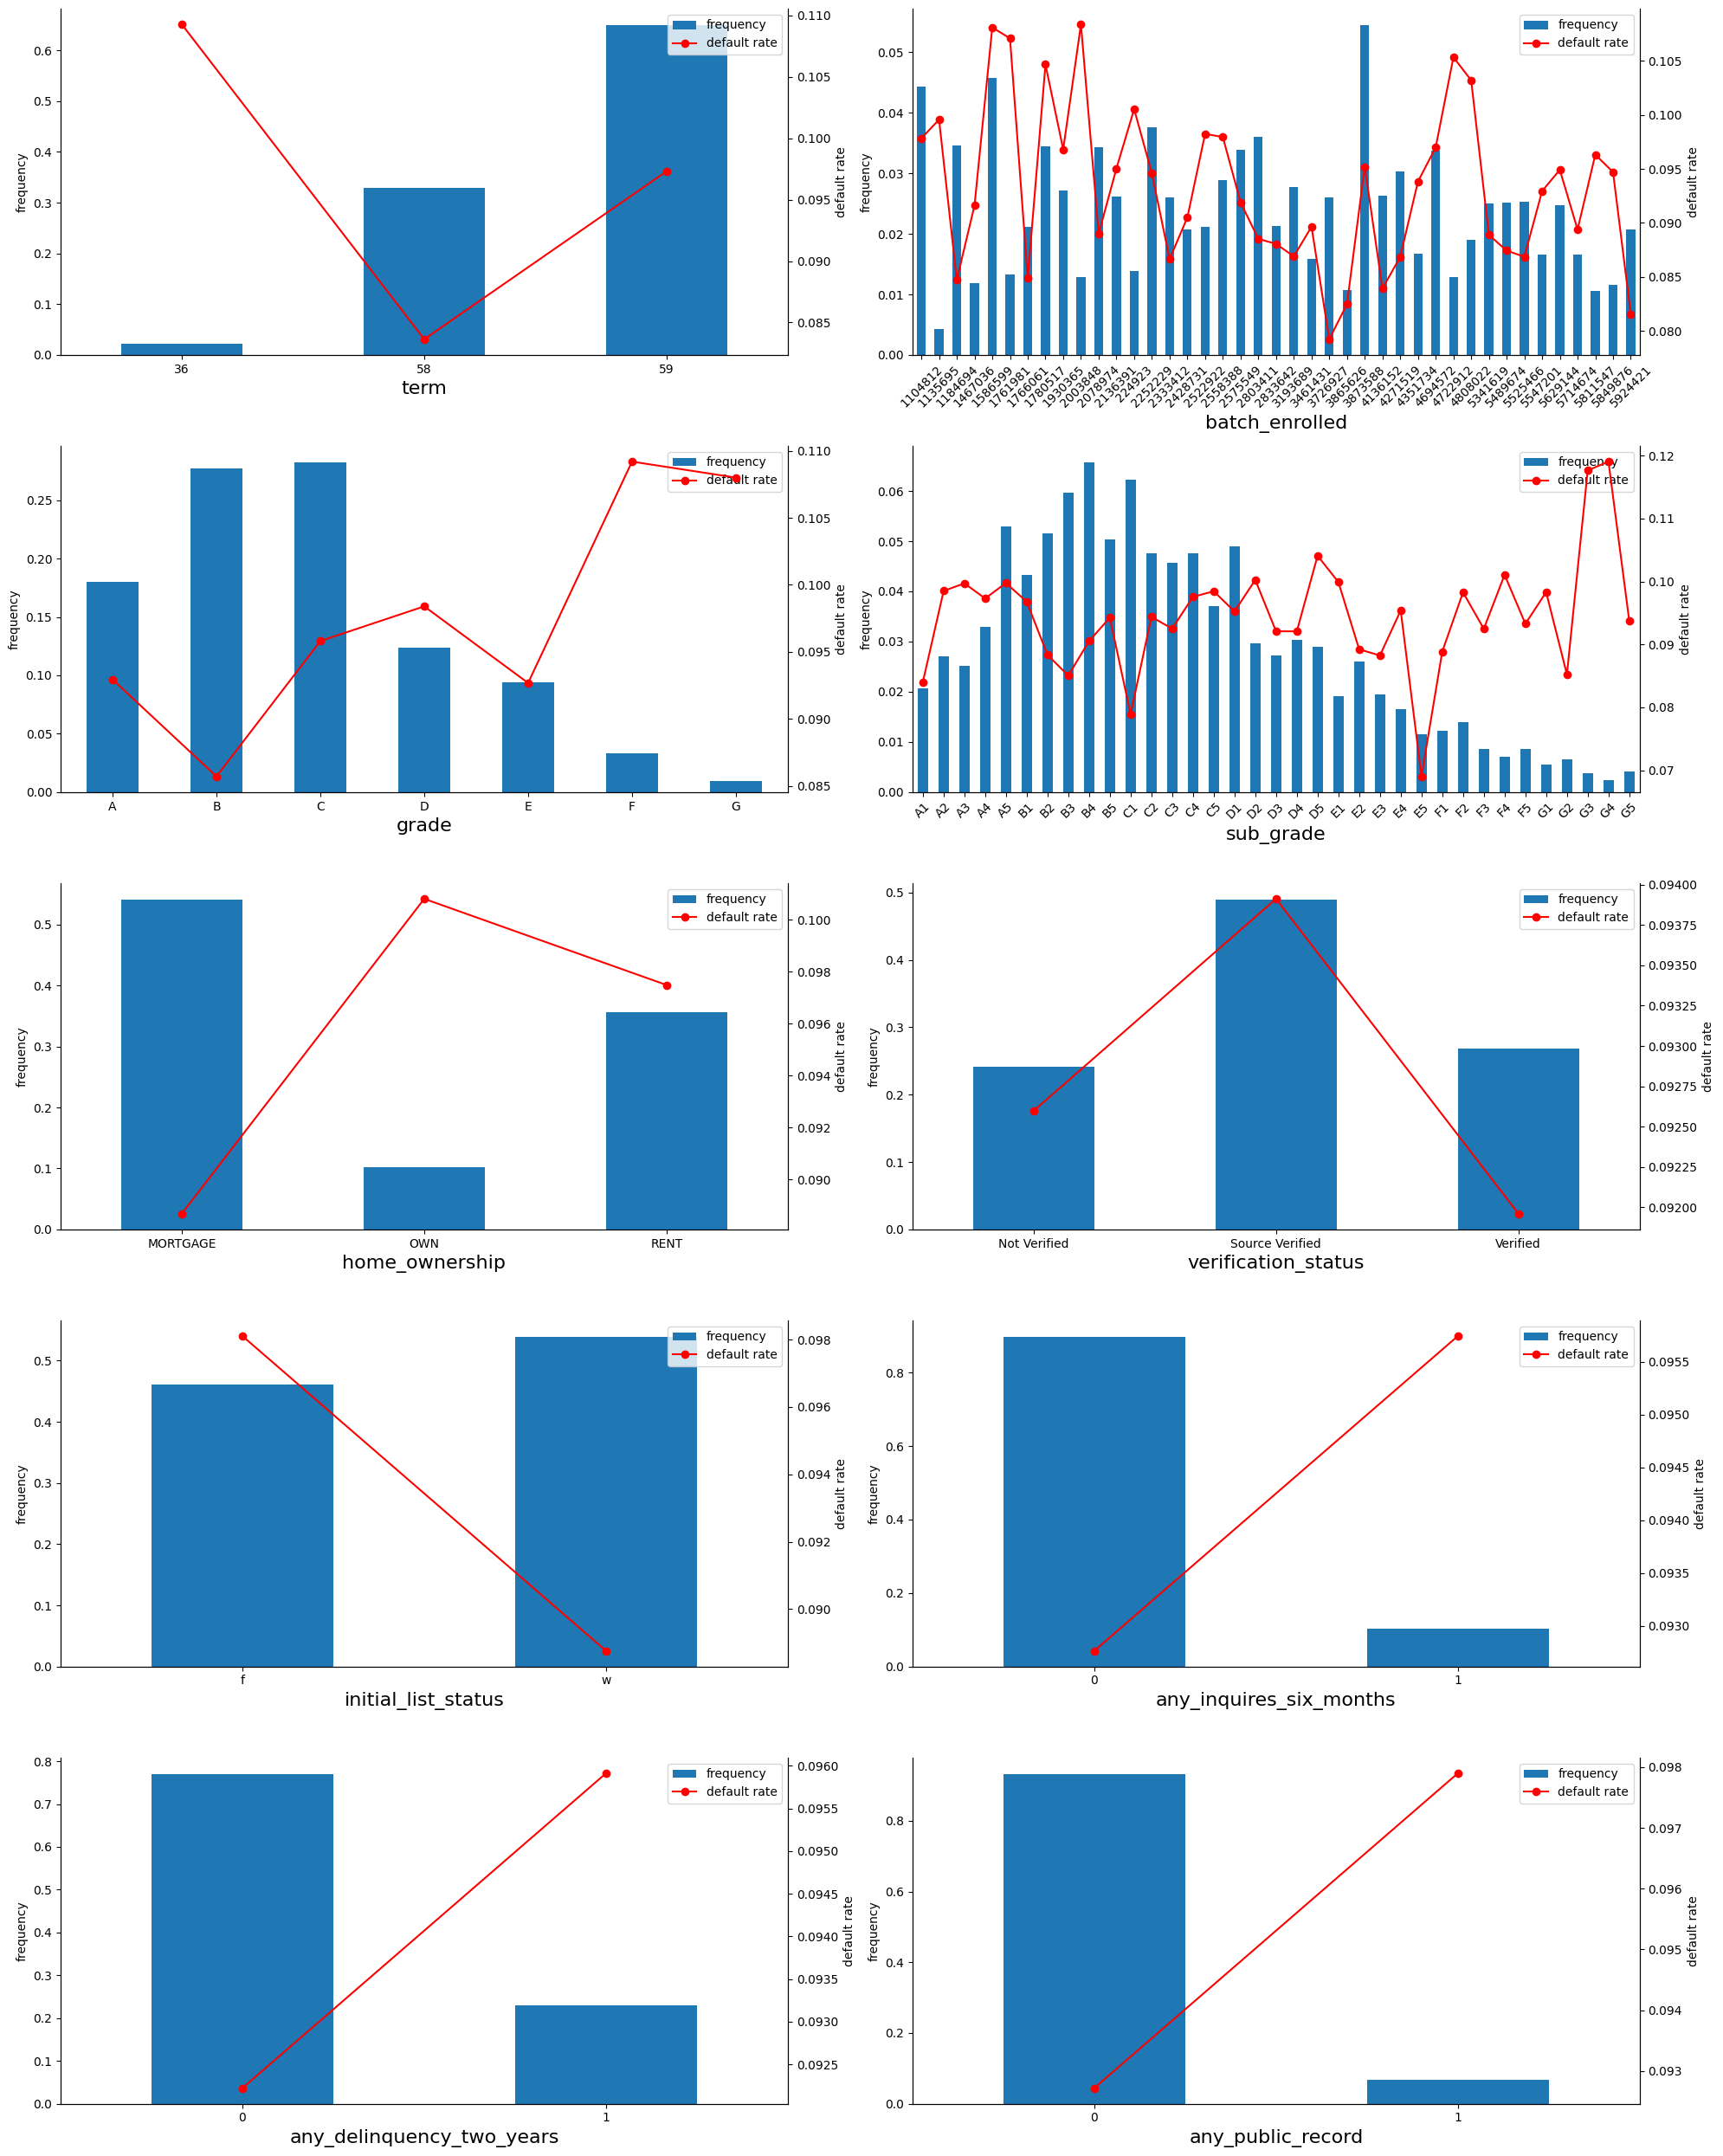

In [31]:
vars_to_plot = [var for var in discrete_vars if var != 'loan_title']

fig, ax = plt.subplots(5, 2, figsize=(20, 25))
ax = ax.ravel()
# fig.delaxes(ax[-1])

for i, var in enumerate(vars_to_plot):
    X_train[var].value_counts(normalize=True).sort_index().plot(kind='bar', ax=ax[i], label='frequency')
    if X_train[var].nunique() > 10:
        ax[i].tick_params(axis='x', rotation=45)
    else:
        ax[i].tick_params(axis='x', rotation=0)
    ax[i].set_ylabel('frequency')
    ax[i].set_xlabel(var, fontsize=16)
    
    ax2 = ax[i].twinx()
    tmp = pd.concat([X_train[var], y_train], axis=1)
    tmp.groupby(var)['loan_status'].mean().plot(ax=ax2, color='r', marker='o', label='default rate')
    ax2.set_ylabel('default rate')

    ax[i].spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    # Combine legends for frequency and default rate into one legend box
    handles1, labels1 = ax[i].get_legend_handles_labels()   # Handles and labels for the frequency
    handles2, labels2 = ax2.get_legend_handles_labels()     # Handles and labels for the default rate
    ax[i].legend(handles1 + handles2, labels1 + labels2, loc='upper right')  # Combined legend

plt.tight_layout()
plt.show()

We notice that these variables can be divided into 3 groups:  binary variables, ordinal variables, and nominal variables

In [32]:
# let's define our groups of variables here
binary_variables = [var for var in discrete_vars if X_train[var].nunique() == 2]
ordinal_variables = ['grade', 'sub_grade']
nominal_variables = [var for var in discrete_vars if var not in binary_variables and var not in ordinal_variables]

### 5.2. Some data cleaning

Some variables are high-cardinality - `loan_title`. In particular, the inconsistent values in `Loan Title` are likely the result of manual data entry. To properly analyze the data in this variable, we need to clean it.

In [33]:
class LoanTitleCleanUp(BaseEstimator, TransformerMixin):
    def __init__(self, feature='loan_title', rare_threshold=0.01):
        self.feature = feature
        self.rare_threshold = rare_threshold
        
    def fit(self, X, y=None):
        self.mapping = {
            'consolidation loan': 'debt consolidation',
            'debt consolidation loan': 'debt consolidation',
            'consolidation': 'debt consolidation',
            'loan': 'other',
            'credit card debt': 'credit card',
            'credit card loan': 'credit card',
            'debt loan': 'other',
            'credit cards': 'credit card',
            'cards': 'credit card',
            'credit consolidation': 'credit card consolidation',
            'credit card refi': 'credit card refinancing',
            'credit card refinance': 'credit card refinancing',
            'debt free': 'debt payoff',
            'bathroom': 'home improvement',
            'dept consolidation': 'debt consolidation',
            'credit cardrefinance': 'credit card refinancing',
            'get out of debt': 'debt payoff',
            'credit loan': 'credit card',
            'car loan': 'major purchase',
            'car financing': 'major purchase',
            'loan consolidation': 'debt consolidation',
            'credit card refinance loan': 'credit card refinancing',
            'credit': 'credit card'
        }
        return self
        
    def transform(self, X):
        X_transformed = X.copy()
        # first, let's convert the values to lower case, remove leading spaces, and remove any special characters
        X_transformed[self.feature] = X[self.feature].str.lower().str.lstrip().str.replace(r'[^a-z\s]', '', regex=True).str.strip()
        # replace synonyms
        X_transformed[self.feature] = X_transformed[self.feature].str.replace('cc', 'credit card')\
                                    .str.replace('cc', 'credit card')\
                                    .str.replace('consolidate', 'consolidation')\
                                    .apply(lambda x: 'medical expenses' if 'medical' in x else x)\
                                    .apply(lambda x: 'home improvement' if 'home' in x else x)\
                                    .apply(lambda x: 'bill payments' if 'bill' in x else x)

        # apply the mapping
        X_transformed[self.feature] = X_transformed[self.feature].replace(self.mapping)

        # Handle rare categories
        frequencies = X_transformed[self.feature].value_counts(normalize=True)
        X_transformed[self.feature] = X_transformed[self.feature].apply(lambda x: 'other' if frequencies[x] < self.rare_threshold else x)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [34]:
# test the transformer - we want to set up a pipeline that can be reused later so for now, we will not overwrite X with our fit & transform method
loan_title_clean = LoanTitleCleanUp('loan_title', 0.0015)

In [35]:
# we can test to see if this transformation works and see how the categories of loan title is updated
X_train_trans = loan_title_clean.fit_transform(X_train, y_train)

X_train_trans['loan_title'].value_counts(normalize=True).sort_values(ascending=False)

loan_title
credit card refinancing      0.457310
debt consolidation           0.430721
other                        0.050009
home improvement             0.036057
major purchase               0.009283
medical expenses             0.003947
credit card                  0.003428
business                     0.002853
moving and relocation        0.002316
credit card consolidation    0.002316
vacation                     0.001760
Name: proportion, dtype: float64

### 5.3. Variable Encoding

One encoding method typically used in credit scoring is **Weight of Evidence**, which quantifies the relationship between a category of a variable and a binary target. In other words, Weight of Evidence is a measure of the "strength” of a grouping technique to separate good and bad risk (default). In doing so, it also creates a monotonic relationships between the encoded variable and the target, which works better with our linear models.

The formula for calculting WoE for a category within a variable is as follows:

$$WOE = ln(\frac {\text{Distribution of events}} {\text{Distribution of non-events}})$$

WoE is especially well suited for linear models like Logistic Regression, because the Logit transformation is simply the log of the odds, i.e., ln(P(Goods)/P(Bads)). Therefore, by using WoE-coded predictors in logistic regression, the predictors are all prepared and coded to the same scale, and the parameters in the linear logistic regression equation can be directly compared.

The WoE transformation has three advantages:

- It creates a monotonic relationship between the target and the independent variables.
- It orders the categories on a "logistic" scale which is natural for logistic regression
- The transformed variables can then be compared because they are on the same scale. Therefore, it is possible to determine which one is more predictive.

Let's create a custom transformer that will apply WoE encoding to our variables.

In [36]:
class WoEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.woe_dict = {}
        
    def fit(self, X, y):
        X_ = X.copy()
        X_['target'] = y
        for var in X.columns:
            # calculate event and non-event prob
            event_prob = X_.groupby(var)['target'].mean()
            non_event_prob = 1 - event_prob
            # calculate woe, handling division by 0 with np.log(1e-6)
            self.woe_dict[var] = np.log((event_prob + 1e-6) / (non_event_prob + 1e-6)).to_dict()

        return self

    def transform(self, X):
        X_transformed = X.copy()
        for var in X.columns:
            X_transformed[var] = X_transformed[var].map(self.woe_dict[var]).fillna(0)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self    

In addition, we can also use **Frequency Encoding**, which involves replacing the category labels with the category's frequency. This encoding method is used quite often in hackathons and Kaggle competitions. So we can also try that with this dataset.

Let's also create our custom transformer that will apply Frequency Encoding.

In [37]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.frequency_dict = {}
    def fit(self, X, y=None):
        for var in X.columns:
            # calculate category frequency
            freq_ = X[var].value_counts(normalize=True).to_dict()
            self.frequency_dict[var] = freq_
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for var in X.columns:
            X_transformed[var] = X[var].map(self.frequency_dict[var]).fillna(0)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self    

#### 5.2.1. Binary variables

Let's create a Frequency Encoder for our binary variables using the transformer we just created. To apply it on our list of binary variables, we can wrap it in an instance of ColumnTransformer. The other variables will be passed through without modification.

In [38]:
binary_enc = ColumnTransformer(
    transformers=[
        ('binary_enc', FrequencyEncoder(), binary_variables)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

#### 5.2.2. Ordinal Variables
Next, let's tackle the ordinal variables. For these variables, it makes sense to replace the string labels with integer representation that captures the order of the values.

In [39]:
class OrdinalLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mappings = {}

    def fit(self, X, y=None):
        for var in X.columns:
            mapping = {k:i for i,k in enumerate(sorted(X[var].unique()), 0)}
            self.mappings[var] = mapping
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for var in X.columns:
            mapping = self.mappings[var]
            X_transformed[var] = X[var].map(mapping)
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [40]:
# create Custom Ordinal Encoder for ordinal variables, we'll also wrap it inside a column transformer
ordinal_label_enc = ColumnTransformer(
    transformers=[
        ('ordinal_label_enc', OrdinalLabelEncoder(), ordinal_variables)     # we only need to apply this to grade since other variables are already of type integer
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

Before we can apply Weight of Evidence transformation on these variables, we'll further group them up to: 1) handle rare categories and 2) ensure that the event rate for each group follows a monotonic trend. To do that, we will use the `OptimalBinning` transformer from an external library called `optbinning`. 

`OptimalBinning` also provides options to transform the binned variables using Weight of Evidence, event rate, or information value. So we'll make use of this functionality when we create our custom transformer below.

In [41]:
class OptBinningTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features, dtype='categorical', solver='cp', monotonic_trend='auto', 
                 user_splits=None, user_splits_fixed=None, transform_metric='woe'):
        self.features = features
        self.dtype = dtype
        self.solver = solver
        self.monotonic_trend = monotonic_trend
        self.user_splits = user_splits or {}
        self.user_splits_fixed = user_splits_fixed or {}
        self.transform_metric = transform_metric
        self.bin_models = {}

    # here we overwrite the fit method with our own fit method using OptimalBinning 
    def fit(self, X, y):
        for feature in self.features:
            # check if user splits for this feature is defined
            user_splits_ = self.user_splits.get(feature)
            user_splits_fixed_ = self.user_splits_fixed.get(feature)
            optb = OptimalBinning(name=feature, dtype=self.dtype, 
                                  user_splits=user_splits_, user_splits_fixed=user_splits_fixed_,
                                  solver=self.solver, monotonic_trend=self.monotonic_trend,)
            optb.fit(X[feature], y)
            if len(optb.splits) > 0:                # check if the binning results in splits, if yes
                self.bin_models[feature] = optb     # save this to the transformer's bin models for access later in transformation
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.features:
            if self.bin_models.get(feature):
                optb = self.bin_models.get(feature)
                X_transformed[feature] = optb.transform(X[feature], metric=self.transform_metric)    # use empirical WoE to transform missing values
        return X_transformed

In [42]:
# create the transformer for these feature
ordinal_enc = OptBinningTransformer(features=ordinal_variables,
                                        dtype='numerical',            # dtype is numerical for ordinal variables
                                        solver='cp',
                                        monotonic_trend='ascending',       # chooses the monotonic trend most likely to maximize the information value
                                        transform_metric='woe',
                                    )

#### 5.2.3. Nominal variables

For the remaining nominal features, we'll also apply OptBinningTransformer to find the optimal binning for the categories (we'll use transform metric = `indices`). And then apply the Frequency Encoder on top of the new bins.

In [43]:
# manually define custom splits for Loan Title
user_splits = {
    'loan_title': np.array([
        ['debt consolidation'],
        ['credit card refinancing'],
        ['credit card consolidation', 'credit card', 'payoff', 'personal loan', 'medical expenses', 'other'],
        ['home improvement', 'major purchase', 'moving and relocation', 'vacation', 'business']
    ], dtype=object)
}

user_splits_fixed = {
    'loan_title': [True, True, True, True]
}

# set up the binning transformer
nominal_binning =  OptBinningTransformer(features=nominal_variables,
                                         dtype='categorical',            # dtype is categorical for nominal variables
                                         solver='cp',
                                         monotonic_trend='auto',
                                         user_splits=user_splits,
                                         user_splits_fixed=user_splits_fixed,
                                         transform_metric='indices')

# set up the frequency encoder
nominal_enc = ColumnTransformer(
    transformers=[
        ('nominal_enc', FrequencyEncoder(), nominal_variables)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

### 5.4. Preprocessing pipeline for discrete variables

In [44]:
# Create the pipeline for discrete variables, we'll do the fit and transform later
discrete_pipeline = Pipeline(steps=[
    ('loan_title_clean', loan_title_clean),
    ('binary_enc', binary_enc),
    ('ordinal_label_enc', ordinal_label_enc),
    ('ordinal_enc', ordinal_enc),
    ('nominal_binning', nominal_binning),
    ('nominal_enc', nominal_enc)
])

## 6. Continuous variables

### 6.1. Quick inspection
Let's take a look at our continuous variables

In [45]:
len(continuous_vars)

42

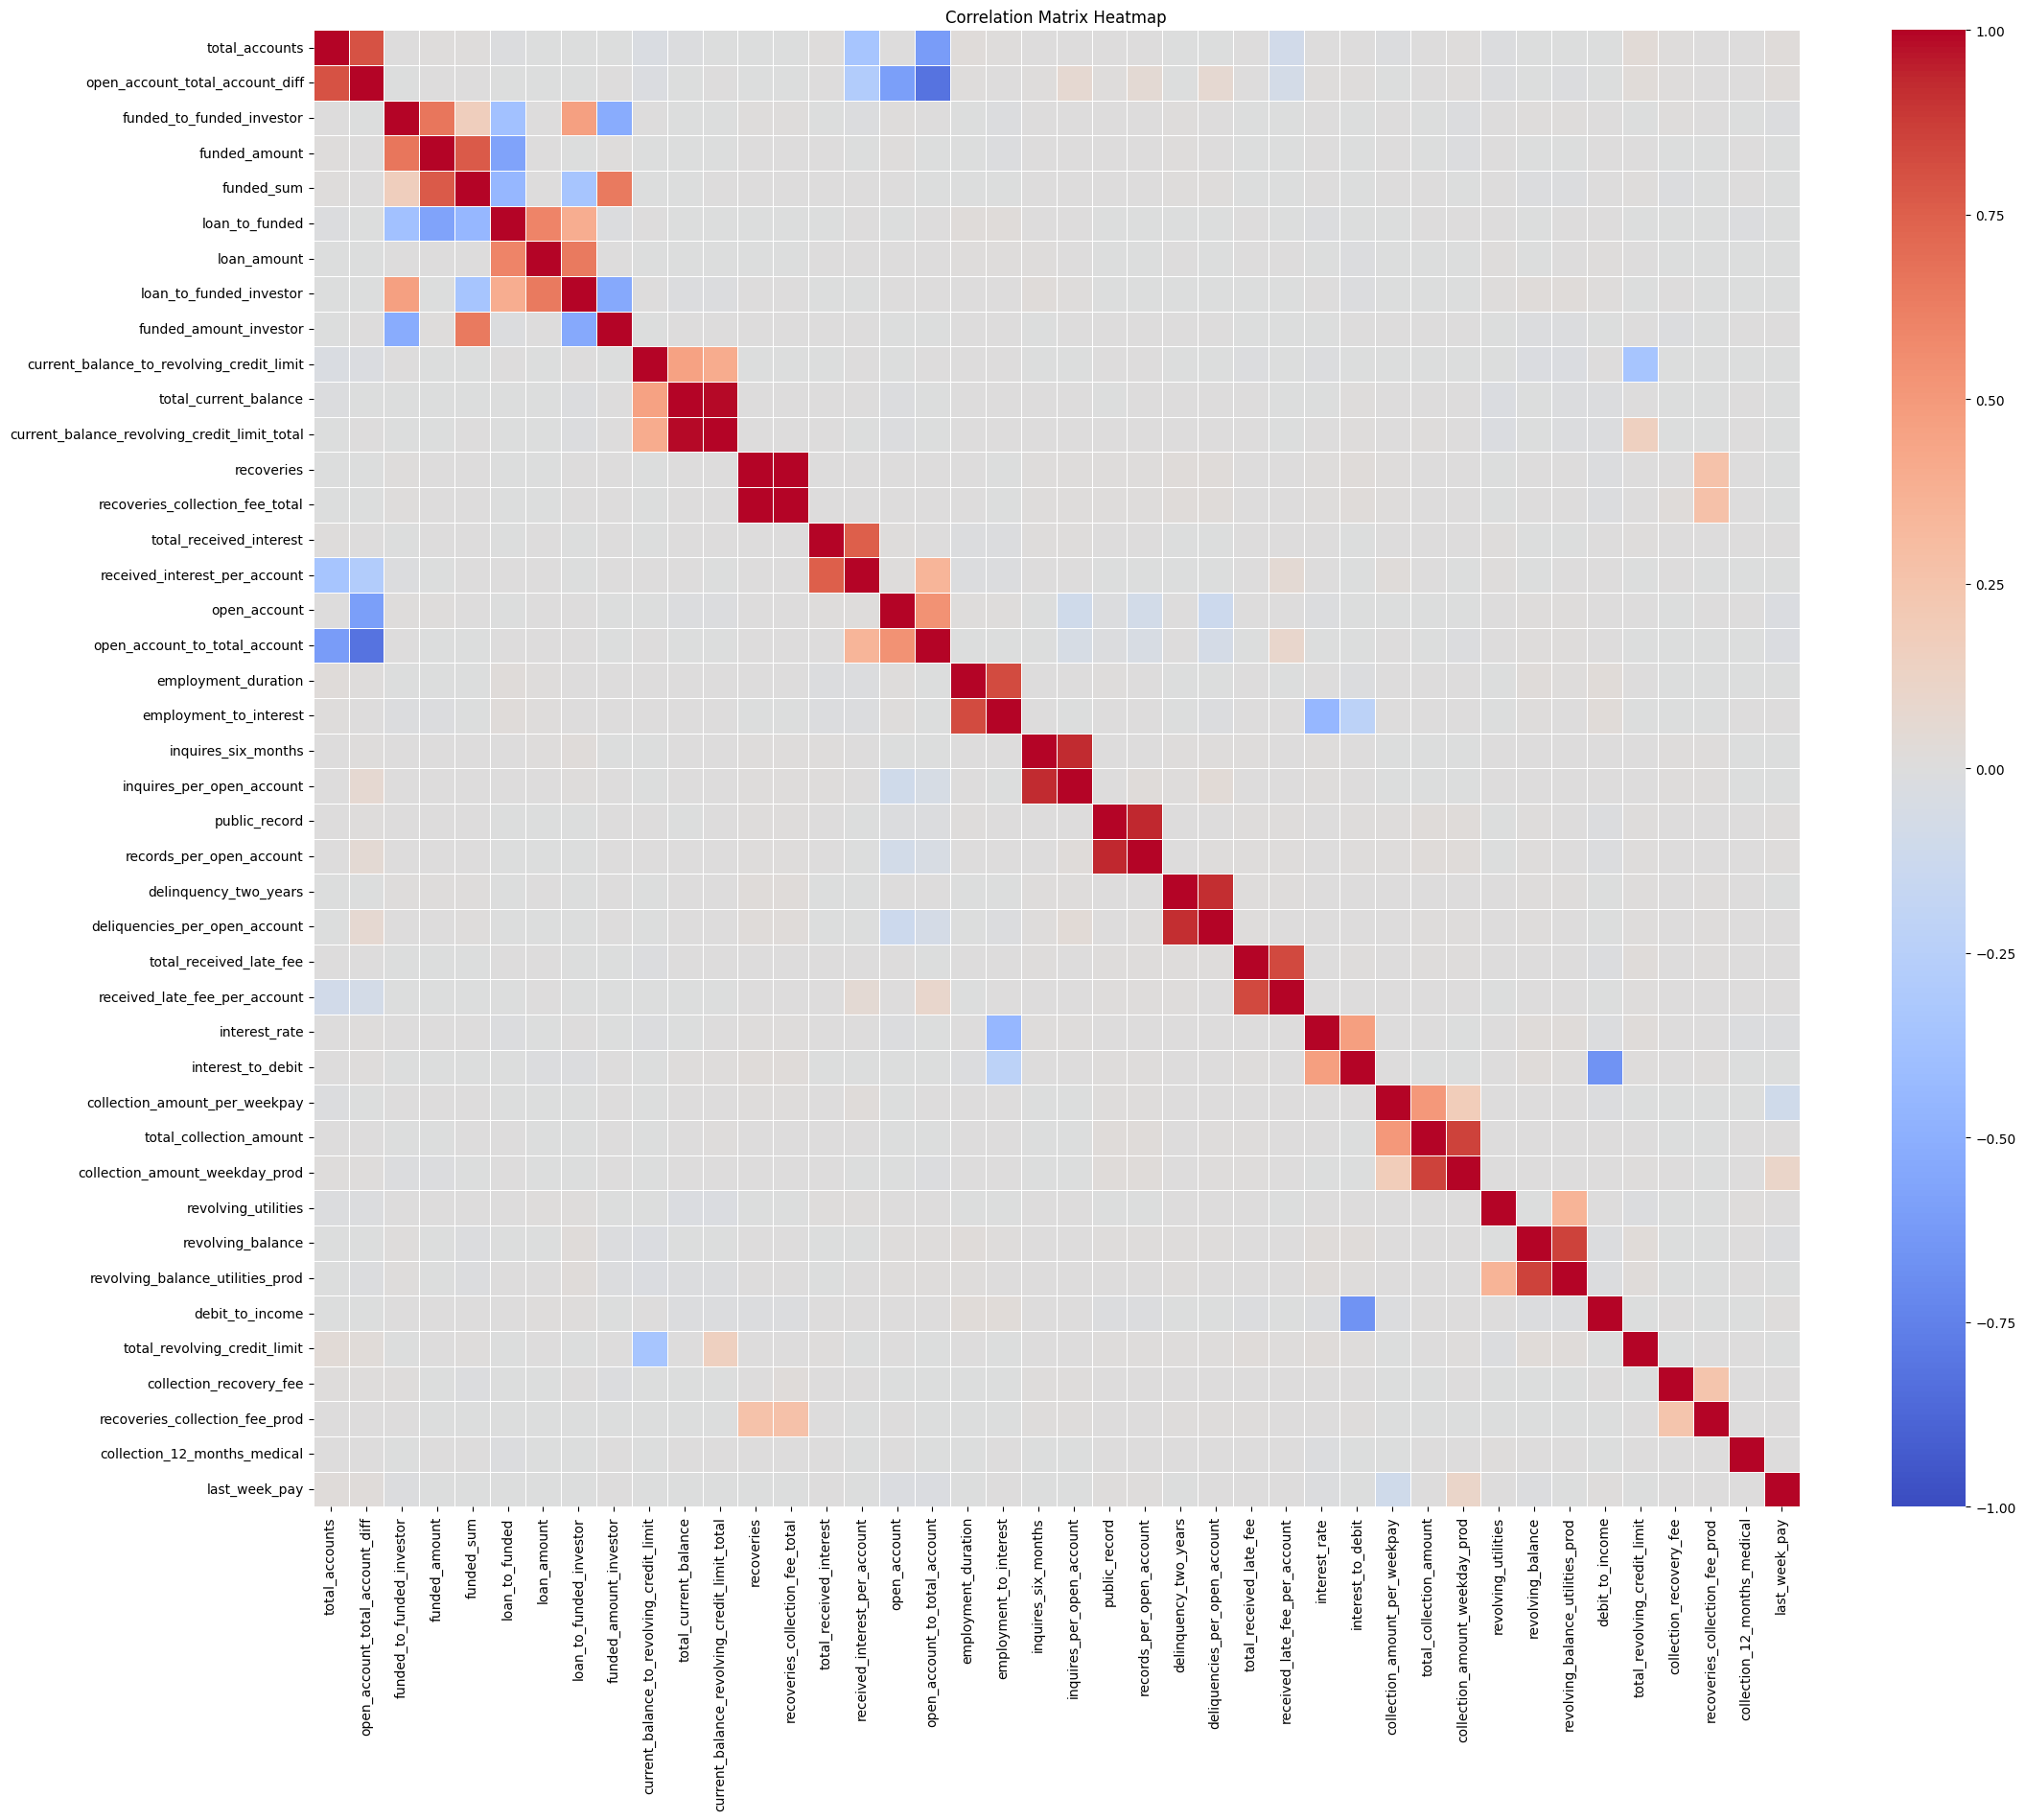

In [46]:
import scipy.cluster.hierarchy as sch

# calculate the correlation among continuous variables
X_corr = X_train[continuous_vars].corr()

# Perform hierarchical clustering to order the correlation matrix
corr_linkage = sch.linkage(X_corr, method='average')
clustered_idx = sch.leaves_list(corr_linkage)

# Reorder the correlation matrix with the clustered indices
X_corr_clustered = X_corr.iloc[clustered_idx, clustered_idx]

# Plot the heatmap with clustered correlation matrix - now we can see the highly correlated variables clustered together more easily
plt.figure(figsize=(25, 20))
sns.heatmap(X_corr_clustered, annot=False, cmap='coolwarm', center=0, vmin=-1, vmax=1, 
            linewidths=.5, fmt='.3f')
plt.title('Correlation Matrix Heatmap')
plt.show()

We can see that other than the extra variables we created being highly correlated with the existing variables used to create them (which makes obvious sense), the majority of our numerical variables are not highly correlated with each other.

In [47]:
# check out the skewness of the distribution 
X_train[continuous_vars].skew().sort_values(ascending=False)

recoveries_collection_fee_prod                  64.821246
collection_amount_weekday_prod                  16.438971
total_collection_amount                         12.723939
collection_recovery_fee                         11.333229
received_late_fee_per_account                    9.107042
records_per_open_account                         7.752153
recoveries                                       7.409348
recoveries_collection_fee_total                  7.407618
collection_12_months_medical                     6.596226
public_record                                    6.319072
current_balance_to_revolving_credit_limit        6.289282
deliquencies_per_open_account                    6.003868
interest_to_debit                                5.457212
total_received_late_fee                          5.054037
inquires_per_open_account                        4.834785
delinquency_two_years                            4.665265
received_interest_per_account                    4.259353
inquires_six_m

A lot of our continuous variables have right-skewed distribution, let's inspect some of them.

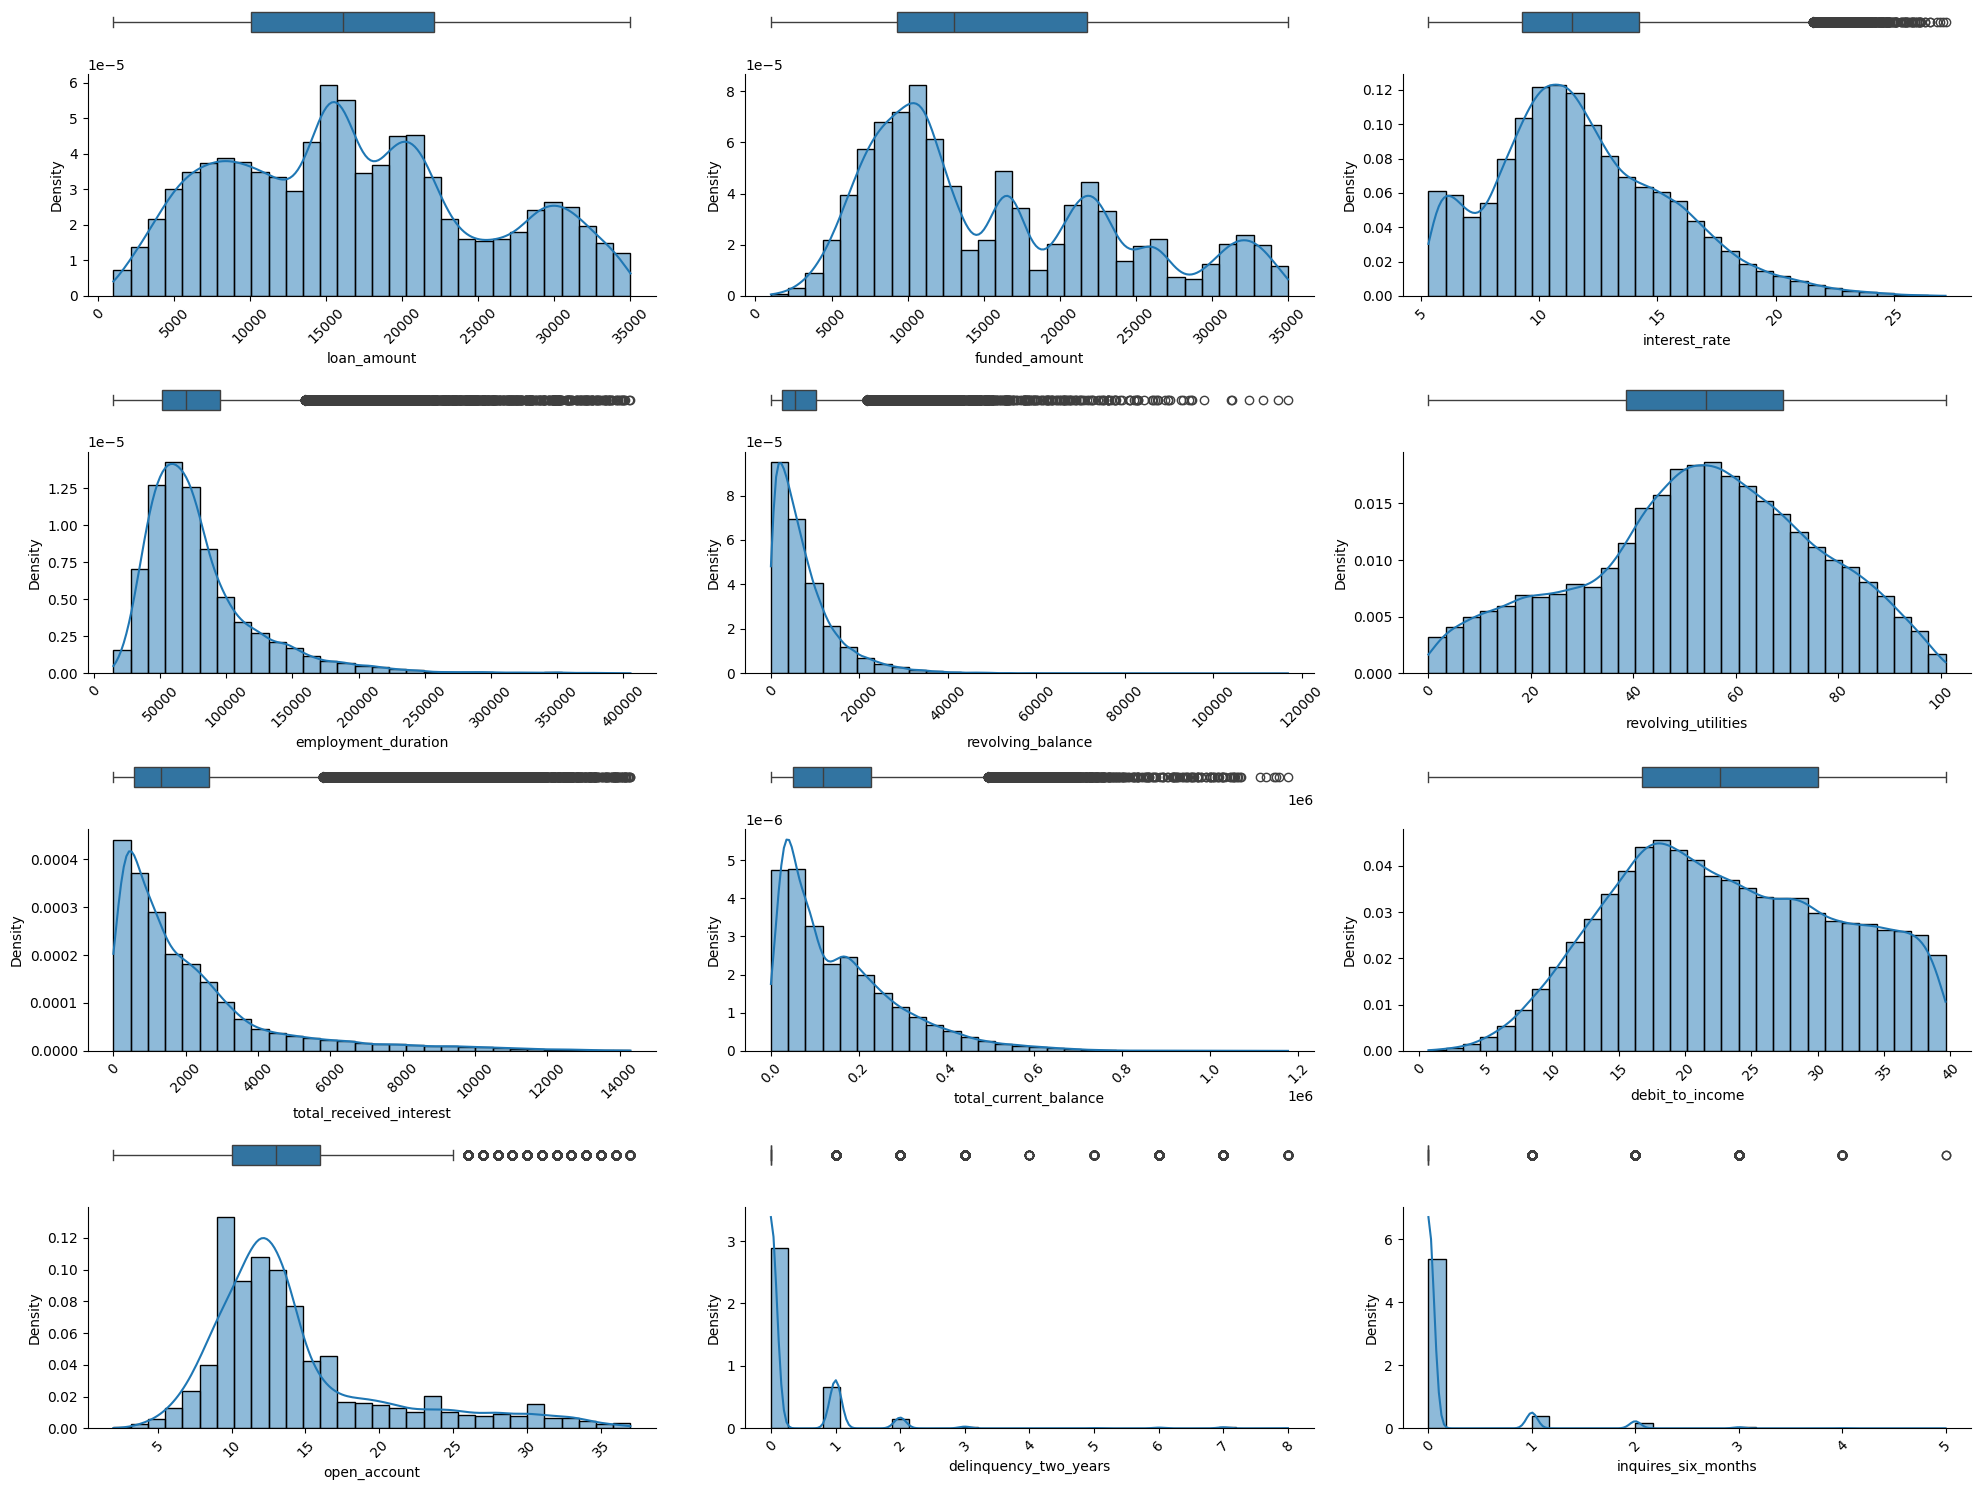

In [48]:
# let's look at the distribution of some variables
vars_to_plot = [
    'loan_amount',
    'funded_amount',
    'interest_rate',
    'employment_duration',
    'revolving_balance',
    'revolving_utilities',
    'total_received_interest',
    'total_current_balance',
    'debit_to_income',
    'open_account',
    'delinquency_two_years',
    'inquires_six_months'
]


fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
ax = ax.ravel()
# fig.delaxes(ax[-1])
# fig.delaxes(ax[-2])

for i, var in enumerate(vars_to_plot):
    # Turn off the visible axes in the main subplot
    ax[i].set_visible(False)
    # Create the nested subplots within each cell of the main grid
    gs = ax[i].get_subplotspec().subgridspec(2, 1, height_ratios=[.1, .9])

    # Create boxplot in the first nested subplot, share the x-axis with the histogram
    ax_box = fig.add_subplot(gs[0], sharex=ax[i])
    sns.boxplot(x=X_train[var], ax=ax_box)
    
    # turn off all the ticks on the axes of the box plot
    ax_box.tick_params(left=False, bottom=False)
    # turn off the title on the box plot
    ax_box.set_xlabel('')
    # turn off all spines (edges) around the box plot
    sns.despine(ax=ax_box, left=True, top=True, right=True, bottom=True)

    # Create histogram in the second nested subplot, share x-axis with the boxplot
    ax_hist = fig.add_subplot(gs[1], sharex=ax_box)
    ax_hist.tick_params(axis='x', rotation=45)
    sns.histplot(x=X_train[var], bins=30, kde=True, stat='density', ax=ax_hist)
    # Remove x-axis ticks from the boxplot (to avoid double labels)
    plt.setp(ax_box.get_xticklabels(), visible=False)

    # Remove extra spines
    sns.despine(ax=ax_hist)

# Increase distance between rows
plt.subplots_adjust(hspace=2.0)  # Adjust this value as needed
plt.tight_layout()
plt.show()

We see many continuous variables are (heavily) right-skewed. So, before applying optimal binning and WoE transformation, we'll need to handle the outliers and then apply some transformation to normalize the distributions.

### 6.2. Outlier handling

We'll use the capping method with the lower threshold = 0.01 and upper threshold = 0.99 to handle outliers.

In [49]:
# create OutlierCapper class
class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=None, upper_quantile=None):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, X, y=None):
        self.lower_bound_ = X.quantile(self.lower_quantile)
        self.upper_bound_ = X.quantile(self.upper_quantile)
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for var in X.columns:
            X_transformed[var] = X[var].clip(lower=self.lower_bound_[var], upper=self.upper_bound_[var])
        return X_transformed

    def set_output(self, transform='pandas'):
        if transform == 'pandas':
            self.output_type_ = 'pandas'
        return self

In [50]:
# create a ColumnTransformer to apply OutlierCapper on our continuous variables

outlier_cap = ColumnTransformer(
    transformers=[
        ('outlier_cap', 
         OutlierCapper(lower_quantile=0.01, upper_quantile=0.99), 
         continuous_vars)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

### 6.3. Skewed distribution handling

The majority of numerical variables' distributions are right-skewed and leptokurtic. Therefore, before discretizing them and applying encoding methods (like Weight of Evidence), we need to transform these variables. There are several methods as below:

1. The **logarithmic transformation** is typically used to handle positively skewed distribution by compressing the values. It converts a variable X using the natural logarithm.
$$X' = log(X+c)$$
Where:
- $X$ is the original variable (strictly positive)
- $X'$ is the transformed variable
- $c$ is a constant added to X to handle cases where $X <= 0$ (commonly set to 1 to avoid taking log of 0)

2. The **Box-Cox transformation** is more flexible than the log transformation because it inlcudes a parameter $\lambda$ that adjusts the transformation depending on the skewness of the distribution.

$$
X' = 
\begin{cases}
\frac{(X^\lambda - 1)}{\lambda} & \text{if } \lambda \neq 0 \\
log(X) & \text{if } \lambda = 0
\end{cases}
$$

Where:
- $X$ is the original variable (strictly positive)
- $X'$ is the transformed variable
- $\lambda$ is a parameter that can be optimized to best normalize the data

3. The **Yeo-Johnson transformation** is an extension of the Box-Cox transformation that is no longer constrained to positive values.
$$
X' = 
\begin{cases} 
\frac{((X + 1)^{\lambda} - 1)}{\lambda} & \text{if } \lambda \neq 0 \text{ and } X \geq 0 \\ 
-\frac{((-X + 1)^{2 - \lambda} - 1)}{2 - \lambda} & \text{if } \lambda \neq 2 \text{ and } X < 0 \\ 
\ln(X + 1) & \text{if } \lambda = 0 \text{ and } X \geq 0 \\ 
-\ln(-X + 1) & \text{if } \lambda = 2 \text{ and } X < 0 
\end{cases}
$$

In [51]:
# initialize a PowerTransformer to apply Yeo-Johnson transformation
yeojohnson_transformer = ColumnTransformer(
    transformers=[
        ('yeojohnson_transformer', 
         PowerTransformer(method='yeo-johnson', standardize=False), 
         continuous_vars)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

### 6.4. Frequency encoding with OptBinning

In [52]:
# set up the binning transformer
continuous_binning = OptBinningTransformer(features=continuous_vars,
                                       dtype='numerical',
                                       solver='cp',
                                       monotonic_trend='auto',
                                      transform_metric='bins')

# set up the frequency encoder
continuous_enc = ColumnTransformer(
    transformers=[
        ('continuous_enc', FrequencyEncoder(), continuous_vars),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [53]:
# Create the pipeline for numerical variables, we'll do the fit and transform later
continuous_pipeline = Pipeline(steps=[
    ('outlier_cap', outlier_cap),
    ('yeojohnson_transformer', yeojohnson_transformer),
    ('continuous_binning', continuous_binning),
    ('continuous_enc', continuous_enc),
])

## 7. Combined preprocessing pipeline

Now that we have the pipelines for processing discrete and continuous variables, let's combine them into one pipeline and use it to transform the variables.

In [54]:
preprocessing_pipeline = Pipeline(steps=[
    ('discrete_pipeline', discrete_pipeline),
    ('continuous_pipeline', continuous_pipeline),
])

In [55]:
# quick inspection of our data shape before transformation
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(53970, 53) (53970,)
(13493, 53) (13493,)


In [56]:
# fit the combined pipeline to the train set
preprocessing_pipeline.fit(X_train, y_train)

Pipeline(steps=[('discrete_pipeline',
                 Pipeline(steps=[('loan_title_clean',
                                  LoanTitleCleanUp(rare_threshold=0.0015)),
                                 ('binary_enc',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('binary_enc',
                                                                   FrequencyEncoder(),
                                                                   ['initial_list_status',
                                                                    'any_inquires_six_months',
                                                                    'any_delinquency_two_years',
                                                                    'any_public_record'])],
                                                    verbose_feature_names_out=False))...
                                                                    'collection_12_months_medical',
                                                                    'last_week_pay',
                                                                    'total_collection_amount',
                                                                    'total_current_balance',
                                                                    'total_revolving_credit_limit',
                                                                    'funded_sum',
                                                                    'loan_to_funded',
                                                                    'loan_to_funded_investor',
                                                                    'funded_to_funded_investor',
                                                                    'employment_to_interest',
                                                                    'interest_to_debit',
                                                                    'deliquencies_per_open_account',
                                                                    'inquires_per_open_account', ...])],
                                                    verbose_feature_names_out=False))]))])

In [57]:
# transform our data
X_train = preprocessing_pipeline.transform(X_train)
X_test = preprocessing_pipeline.transform(X_test)

In [58]:
# inspect the data shape after transformation
X_train.shape, X_test.shape

((53970, 53), (13493, 53))

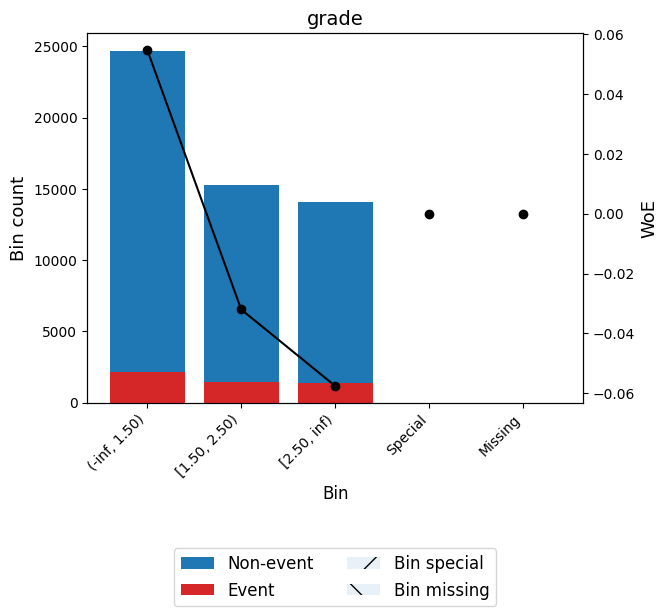

In [60]:
# we can inspect some of the WoE transformed variables
# e.g. grade - the bin model is stored in our pipeline after transformation
# and we can extract the binning table and use it to plot the count and WoE of the bins using optbinning functions
binning_table_grade = preprocessing_pipeline.named_steps['discrete_pipeline']['ordinal_enc'].bin_models['grade'].binning_table
binning_table_grade.build()
binning_table_grade.plot(metric='woe', show_bin_labels=True)

In [61]:
# let's save this preprocessing pipeline
with open('preprocessing_pipeline.pkl', 'wb') as file:
    pickle.dump(preprocessing_pipeline, file)

In [62]:
X_train.shape, X_test.shape

((53970, 53), (13493, 53))

In [63]:
# let's also save our preprocessed train dataset
X_train.to_csv('./data/X_train.csv', index=False)
y_train.to_csv('./data/y_train.csv', index=False)

X_test.to_csv('./data/X_test.csv', index=False)
y_test.to_csv('./data/y_test.csv', index=False)

## 8. Modeling

Now that we have preprocessed our data, let's see which variables are most important for predicting loan default.

In this circumstances, as all the people would have less than 50% of probability to be a defaulter, any model would predict only 0s. Metrics like accuracy score, precision, f1 score, recall and AUC wouldn't be effective for this problem. Because of this, the organizers of the hackathon chose a metric based on the probability of a person to be a defaulter or not. The metric chosen was the log-loss metric. Therefore, in this project, we will also use log-loss as our metric to compare different models' performance.

Formula for calculate log-loss:
$$\frac {-\sum_{i=1}^N w_i(c_i log(p_i) + (1-c_i)log(1-p_i))}{\sum_{i=1}^N w_i}$$

In reality, however, ROC-AUC or its rescaled version, Gini, is used more often for assessing the discriminatory power of a default prediction model.

### 8.1. Benchmark model - Logistic regression

We'll start with a simple Logistic regression model and use it as a benchmark to compare against other classifier.

In [3]:
# load the processed variables and target
X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')

X_test = pd.read_csv('./data/X_test.csv')
y_test = pd.read_csv('./data/y_test.csv')

In [4]:
X_train.shape, X_test.shape

((53970, 53), (13493, 53))

In [5]:
# check the number of each classes in the train and test set
print('Train set')
print(y_train['loan_status'].value_counts())

print('Test set')
print(y_test['loan_status'].value_counts())

Train set
loan_status
0    48947
1     5023
Name: count, dtype: int64
Test set
loan_status
0    12275
1     1218
Name: count, dtype: int64


First, we'll try to remove correlated features.

In [6]:
# logistic regression model
lr = LogisticRegression(C=0.5, max_iter=1000, random_state=42)

# correlation selector
sel = SmartCorrelatedSelection(
    variables=None, # if none, selector examines all numerical variables
    method="pearson",
    threshold=0.5,    # (absolute) correlation coefficient threshold
    missing_values="raise",
    selection_method="model_performance",
    estimator=lr,
    scoring="neg_log_loss",
    cv=5,
)

# this may take a while, because we are training
# a random forest per correlation group

sel.fit(X_train, y_train)

SmartCorrelatedSelection(cv=5,
                         estimator=LogisticRegression(C=0.5, max_iter=1000,
                                                      random_state=42),
                         missing_values='raise', scoring='neg_log_loss',
                         selection_method='model_performance', threshold=0.5)

In [7]:
sel.correlated_feature_sets_

[{'any_delinquency_two_years',
  'delinquency_two_years',
  'deliquencies_per_open_account'},
 {'any_inquires_six_months',
  'inquires_per_open_account',
  'inquires_six_months'},
 {'any_public_record', 'public_record', 'records_per_open_account'},
 {'open_account_to_total_account', 'open_account_total_account_diff'},
 {'recoveries', 'recoveries_collection_fee_total'},
 {'revolving_balance', 'revolving_balance_utilities_prod'}]

In [8]:
# the transformer retains 1 best performing feature from each group of correlated feature
# the rest will be dropped
sel.features_to_drop_

['any_delinquency_two_years',
 'deliquencies_per_open_account',
 'any_inquires_six_months',
 'inquires_per_open_account',
 'any_public_record',
 'public_record',
 'open_account_total_account_diff',
 'recoveries',
 'revolving_balance']

In [9]:
# drop correlated features

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((53970, 44), (13493, 44))

After removing correlated features, we can proceed with training our model.

In [71]:
# define the model
lr = LogisticRegression(penalty='l1', 
                        C=10.0, 
                        solver='saga', 
                        random_state=42, 
                        max_iter=1000,
                       n_jobs=-1)

# hyperparameter space - we'll end up with 6 trials
param_grid = dict(
    penalty=['l1', 'l2'],
    C=[1.0, 5.0, 10.0],
)

# Stratified K-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

# set up grid search to find best hyperparameters
clf = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='neg_log_loss',               # we're minimizing log-loss (or maximizing the negative log-loss)
    cv=kf,
    refit=True,                           # refit the best model to entire dataset
)

In [72]:
# perform the search - this will take some time
search = clf.fit(X_train, y_train)

In [73]:
# see the best hyperparameters
search.best_params_

{'C': 1.0, 'penalty': 'l1'}

In [74]:
# check out the best score (log-loss) achieved
# note that we used negative log-loss as our scoring metric
# so we need to take the absolute value of the best score
-search.best_score_

0.3092408865881347

In [75]:
# check out the mean and standard deviation of scoring metric with different trials
results = pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

results.head()

params  mean_test_score  std_test_score
0   {'C': 1.0, 'penalty': 'l1'}        -0.309241        0.000480
1   {'C': 1.0, 'penalty': 'l2'}        -0.309272        0.000498
2   {'C': 5.0, 'penalty': 'l1'}        -0.309287        0.000507
3   {'C': 5.0, 'penalty': 'l2'}        -0.309294        0.000511
4  {'C': 10.0, 'penalty': 'l1'}        -0.309295        0.000510

Let's plot the mean along with standard deviation log-loss over each hyperparemeter space that we tried.

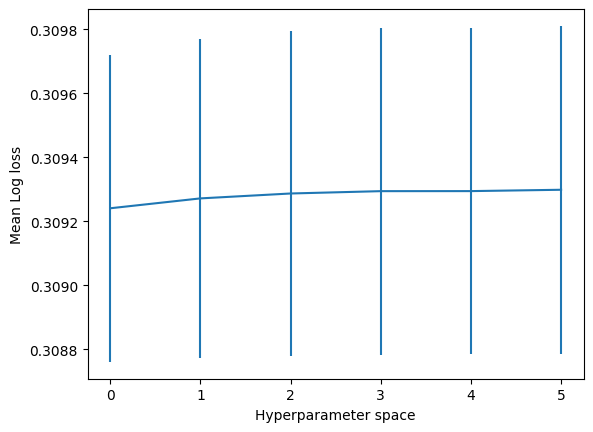

In [76]:
# results.sort_values(by='mean_test_score', ascending=True, inplace=True)

results.reset_index(drop=True, inplace=True)

results['mean_test_score'].abs().plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean Log loss')

plt.xlabel('Hyperparameter space')
plt.show()

Let's use the model with the optimized parameters to get the predictions and evaluate the log-loss on the train and test set.

In [77]:
# let's get the predictions
train_preds = search.predict_proba(X_train)[:, 1]
test_preds = search.predict_proba(X_test)[:, 1]

# evaluate the log loss
print(f'Train Log-loss: {log_loss(y_train, train_preds):.4f}')
print(f'Test Log-loss: {log_loss(y_test, test_preds):.4f}')

# evaluate the roc-auc
print(f'Train roc-auc: {roc_auc_score(y_train, train_preds):.4f}')
print(f'Test roc-auc: {roc_auc_score(y_test, test_preds):.4f}')

Train Log-loss: 0.3085
Test Log-loss: 0.3024
Train roc-auc: 0.5477
Test roc-auc: 0.5391


We can also assess feature importance by accessing the feature coefficients.

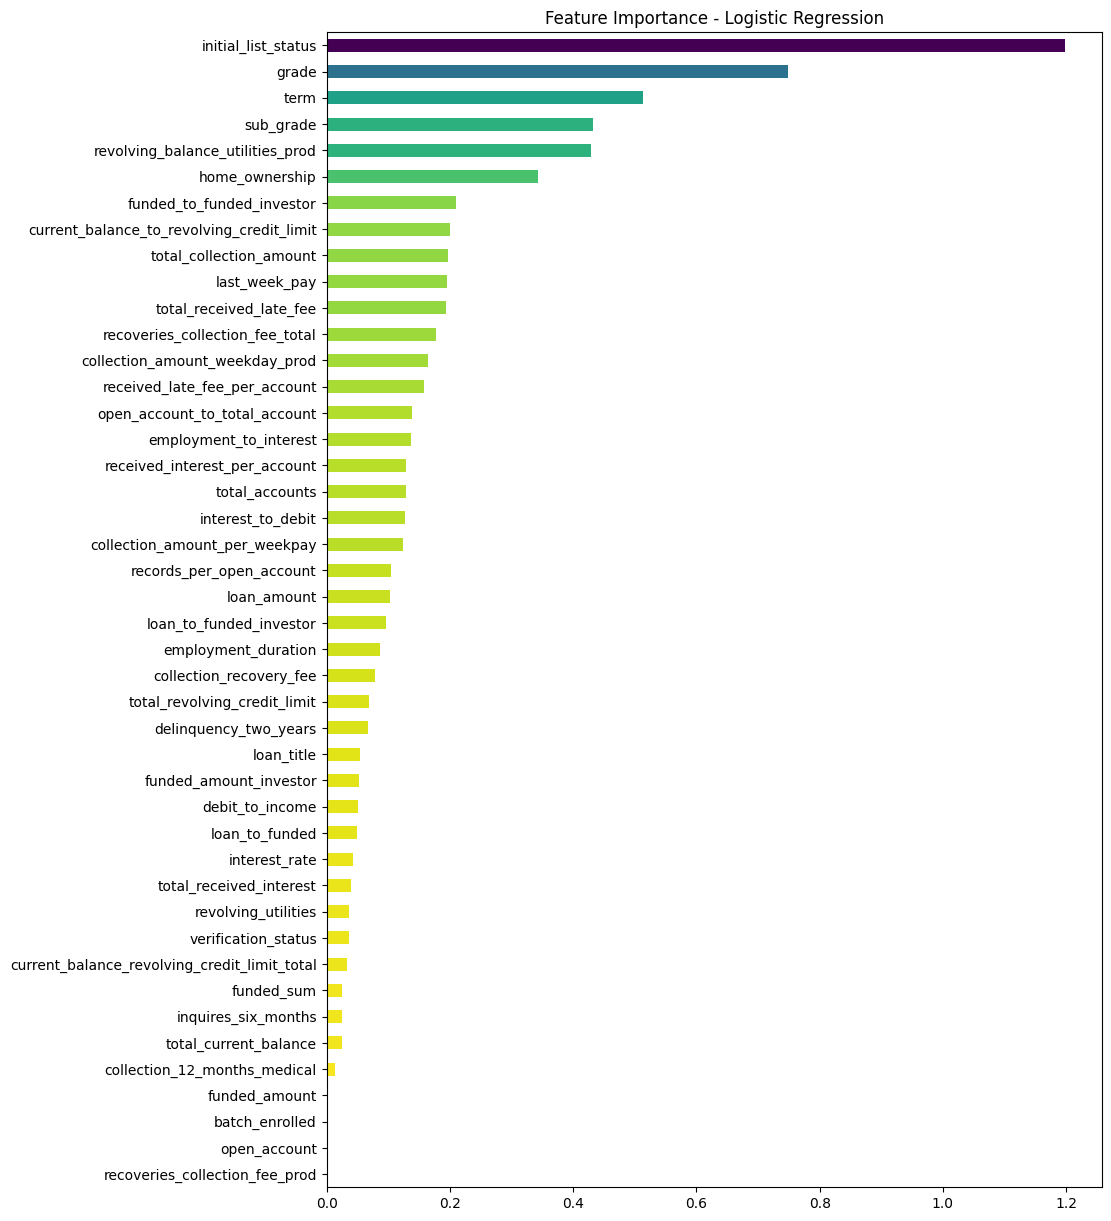

In [78]:
feature_coef = search.best_estimator_.coef_[0]
feature_importance = pd.Series(feature_coef, index=X_train.columns)

# check out the top 20 most important features
# Create a colormap
cmap = plt.get_cmap("viridis_r")

# Normalize the importance values to be between 0 and 1 for color mapping
norm = plt.Normalize(feature_importance.abs().min(), feature_importance.abs().max())

# Create a color array based on the normalized importance
colors = [cmap(norm(value)) for value in feature_importance.abs().sort_values()]

feature_importance.abs().sort_values().plot(kind='barh', figsize=(10, 15), color=colors)
plt.title('Feature Importance - Logistic Regression')
plt.show()

Since the final logistic regression model uses L1 regularization, some of the features' coefficients are shrink to 0. The top 6 features are: `initial_list_status`, `sub_grade`, `grade`, `term`, `revolving_balance_utilities_prod`, `home_ownership`.

In [79]:
# save this model
with open('lr_model.pkl', 'wb') as file:
    pickle.dump(search.best_estimator_, file)

We can wrap up our analysis here. But in the spirit of science, let's try out some other models to see if we can do better in terms of performance.

### 8.2. Challenger models

Let's see if a non-linear model can achieve better performance than the benchmark model. We'll use the same features selected above for the models.

In [80]:
X_train.shape, X_test.shape

((53970, 44), (13493, 44))

Let's play with some hyperparameter tuning using our feature subset. We'll set our metric to be optimized to be Logloss. We will use `optuna` to define an objective function to be optimized.

#### 8.2.1. Random Forest Classifier

In [81]:
def objective(trial):
    # set up the parameters for the LGBM classifier
    param = {
        'criterion': 'log_loss',
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'min_samples_split': trial.suggest_categorical('min_samples_split', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
        'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'random_state': 42,
    }
    # create a model with the parameters
    model = RandomForestClassifier(**param)

    # Stratified K-fold cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
    log_losses = []
    # roc_auc = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model
        model.fit(X_fold_train, y_fold_train)
        
        # Predict probabilities for log loss calculation
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]

        # Calculate log loss for this fold
        fold_log_loss = log_loss(y_fold_val, y_pred_proba)  # Use predicted probabilities for log loss
        log_losses.append(fold_log_loss)

        # calculate roc-auc for this fold
        fold_auc = roc_auc_score(y_fold_val, y_pred_proba)
        # roc_auc.append(fold_auc)

    # Return the mean log loss across all folds
    avg_log_loss = np.mean(log_losses)
    # return mean roc auc across all folds
    # avg_roc_auc = np.mean(roc_auc)
    # return avg_log_loss, avg_roc_auc
    return avg_log_loss

Now we create a study to optimize our loss function. This will take a while to run.

In [82]:
# create a study
study = optuna.create_study(
    study_name='rf_study',   # name for our study
    direction="minimize",      # we are trying to minimize the logloss function and maximizing roc-auc
    sampler=optuna.samplers.TPESampler(),     # Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
    pruner=optuna.pruners.HyperbandPruner()   # Hyperband Pruner to stop the trials if no improvement is made
)

# set the number of trials to be 50
try:
    study.optimize(objective, n_trials=50)
except:
    raise

[I 2024-11-09 16:24:53,668] A new study created in memory with name: rf_study
[I 2024-11-09 16:25:14,593] Trial 0 finished with value: 0.30959593561876975 and parameters: {'n_estimators': 895, 'min_samples_split': 0.5, 'min_samples_leaf': 0.3, 'max_depth': 9}. Best is trial 0 with value: 0.30959593561876975.
[I 2024-11-09 16:25:28,360] Trial 1 finished with value: 0.3095842766269869 and parameters: {'n_estimators': 980, 'min_samples_split': 0.5, 'min_samples_leaf': 0.8, 'max_depth': 9}. Best is trial 1 with value: 0.3095842766269869.
[I 2024-11-09 16:25:53,286] Trial 2 finished with value: 0.30930308691111896 and parameters: {'n_estimators': 795, 'min_samples_split': 0.3, 'min_samples_leaf': 0.1, 'max_depth': 3}. Best is trial 2 with value: 0.30930308691111896.
[I 2024-11-09 16:26:09,494] Trial 3 finished with value: 0.30944860205939884 and parameters: {'n_estimators': 644, 'min_samples_split': 0.2, 'min_samples_leaf': 0.2, 'max_depth': 7}. Best is trial 2 with value: 0.309303086911118

In [83]:
# examine the best parameters found during the trials
study.best_params

{'n_estimators': 712,
 'min_samples_split': 0.1,
 'min_samples_leaf': 0.1,
 'max_depth': 4}

In [84]:
study.best_value

0.30927886219499795

In [85]:
# the result and parameters for each trial is also recorded in a dataframe
study.trials_dataframe().head()

number     value             datetime_start          datetime_complete  \
0       0  0.309596 2024-11-09 16:24:53.670855 2024-11-09 16:25:14.593137   
1       1  0.309584 2024-11-09 16:25:14.594279 2024-11-09 16:25:28.359971   
2       2  0.309303 2024-11-09 16:25:28.361332 2024-11-09 16:25:53.286789   
3       3  0.309449 2024-11-09 16:25:53.287986 2024-11-09 16:26:09.493908   
4       4  0.309584 2024-11-09 16:26:09.494924 2024-11-09 16:26:19.591316   

                duration  params_max_depth  params_min_samples_leaf  \
0 0 days 00:00:20.922282                 9                      0.3   
1 0 days 00:00:13.765692                 9                      0.8   
2 0 days 00:00:24.925457                 3                      0.1   
3 0 days 00:00:16.205922                 7                      0.2   
4 0 days 00:00:10.096392                 6                      0.9   

   params_min_samples_split  params_n_estimators     state  
0                       0.5                  895  COMPLETE  
1                       0.5                  980  COMPLETE  
2                       0.3                  795  COMPLETE  
3                       0.2                  644  COMPLETE  
4                       0.4                  641  COMPLETE

In [86]:
# save this trials result dataframe
study.trials_dataframe().to_csv('./data/rf_trials.csv', index=False)

With a `RandomForestClassifier`, we achieved lowest log-loss at around 0.309. Let's see which hyperparameters were most influential on the loss function.

In [87]:
# plot hyperparameter importances
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [88]:
# see how the hyperparameters affect the loss function
fig = optuna.visualization.plot_contour(study)

fig.update_layout(
    width=1000,                           # Set the desired width of the figure
    height=1000,                         # Set the desired height of the figure
)

pio.show(fig)

Let's see how the model with the best parameter performs on the train and test set.

In [89]:
study.best_params

{'n_estimators': 712,
 'min_samples_split': 0.1,
 'min_samples_leaf': 0.1,
 'max_depth': 4}

In [90]:
# save the best params to a json file
with open('rf_params.json', 'w') as file:
    json.dump(study.best_params, file, indent=4)
    # json.dump(study.best_trials[0].params, file, indent=4)

In [91]:
# retrieve the best parameters from the study
with open('rf_params.json', 'r') as file:
    best_rf_params = json.load(file)


best_rf_params

{'n_estimators': 712,
 'min_samples_split': 0.1,
 'min_samples_leaf': 0.1,
 'max_depth': 4}

In [92]:
# create a model with the parameters and fit it
model = RandomForestClassifier(criterion='log_loss',
                               **best_rf_params)

model.fit(X_train, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=4, min_samples_leaf=0.1,
                       min_samples_split=0.1, n_estimators=712)

Let's use the model with the optimized parameters to get the predictions and evaluate the log-loss on the train and test set.

In [93]:
# let's get the predictions
train_preds = model.predict_proba(X_train)[:, 1]
test_preds = model.predict_proba(X_test)[:, 1]

print(f'Train Log-loss: {log_loss(y_train, train_preds):.4f}')
print(f'Test Log-loss: {log_loss(y_test, test_preds):.4f}')

print(f'Train roc-auc: {roc_auc_score(y_train, train_preds):.4f}')
print(f'Test roc-auc: {roc_auc_score(y_test, test_preds):.4f}')

Train Log-loss: 0.3091
Test Log-loss: 0.3028
Train roc-auc: 0.5570
Test roc-auc: 0.5453


With the `RandomForestClassifier`, we did not achieve better log-loss on the test set compared to the benchmark model. We did, however, achieve higher ROC-AUC score.

In [94]:
# save this model
import pickle
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(model, file)

#### 8.2.2. Light GBM Classifier

In [95]:
def objective(trial):
    # set up the parameters for the LGBM classifier
    param = {
        'metric': 'logloss',
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 1.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.009, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]),
        'n_estimators': trial.suggest_int('n_estimators', 600, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 16, 128),
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 7, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 150, 300),
        'random_state': 42,
        'verbose': -1,
        # 'scale_pos_weight': trial.suggest_loguniform('scale_pos_weight', 8.0, 12.0),
        
    }
    # create a model with the parameters
    model = LGBMClassifier(**param)

    # Cross-validation to optimize log loss
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
    log_losses = []
    # roc_auc=[]

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model
        model.fit(X_fold_train, y_fold_train)
        
        # Predict probabilities for log loss calculation
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]

        # Calculate log loss for this fold
        fold_log_loss = log_loss(y_fold_val, y_pred_proba)  # Use predicted probabilities for log loss
        log_losses.append(fold_log_loss)

        # # calculate roc-auc for this fold
        # fold_auc = roc_auc_score(y_fold_val, y_pred_proba)
        # roc_auc.append(fold_auc)

    # Return the mean log loss across all folds
    avg_log_loss = np.mean(log_losses)
    # # return mean roc auc across all folds
    # avg_roc_auc = np.mean(roc_auc)
    return avg_log_loss

Now we create a study to optimize our loss function. This will take a while to run.

In [96]:
# create a study
study = optuna.create_study(
    study_name='lgbm_study',   # name for our study
    direction="minimize",      # we are trying to minimize the logloss function
    sampler=optuna.samplers.TPESampler(),     # Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
    pruner=optuna.pruners.HyperbandPruner()   # Hyperband Pruner to stop the trials if no improvement is made
)

# set the number of trials to be 50
try:
    study.optimize(objective, n_trials=50)
except:
    raise

[I 2024-11-09 16:47:41,219] A new study created in memory with name: lgbm_study
[I 2024-11-09 16:47:47,454] Trial 0 finished with value: 0.3088568412228544 and parameters: {'reg_lambda': 2.28108933403307, 'reg_alpha': 0.010862631485193206, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.008, 'n_estimators': 774, 'num_leaves': 27, 'min_child_samples': 231, 'max_depth': 9, 'min_child_weight': 284}. Best is trial 0 with value: 0.3088568412228544.
[I 2024-11-09 16:47:53,597] Trial 1 finished with value: 0.30863723883281347 and parameters: {'reg_lambda': 6.10995863247537, 'reg_alpha': 0.9725736438778357, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.014, 'n_estimators': 746, 'num_leaves': 23, 'min_child_samples': 157, 'max_depth': 9, 'min_child_weight': 265}. Best is trial 1 with value: 0.30863723883281347.
[I 2024-11-09 16:48:00,257] Trial 2 finished with value: 0.3088217078853546 and parameters: {'reg_lambda': 9.161824312182567, 'reg_alpha': 0.014323272194999

In [97]:
# examine the best parameters found during the trials
study.best_params
# sorted(study.best_trials, key=lambda x: x.values[1], reverse=True)[0].params

{'reg_lambda': 3.9752389222703144,
 'reg_alpha': 0.12818660561996767,
 'colsample_bytree': 0.3,
 'subsample': 0.7,
 'learning_rate': 0.01,
 'n_estimators': 930,
 'num_leaves': 122,
 'min_child_samples': 132,
 'max_depth': 16,
 'min_child_weight': 158}

In [98]:
# examine the best value (i.e. lowest logloss achieved)
# sorted(study.best_trials, key=lambda x: x.values[1], reverse=True), reverse=True)[0].values
study.best_value

0.30790792639328235

In [99]:
# the result and parameters for each trial is also recorded in a dataframe
study.trials_dataframe().head()

number     value             datetime_start          datetime_complete  \
0       0  0.308857 2024-11-09 16:47:41.222272 2024-11-09 16:47:47.453485   
1       1  0.308637 2024-11-09 16:47:47.455318 2024-11-09 16:47:53.596727   
2       2  0.308822 2024-11-09 16:47:53.597862 2024-11-09 16:48:00.256954   
3       3  0.308818 2024-11-09 16:48:00.258085 2024-11-09 16:48:07.066378   
4       4  0.309349 2024-11-09 16:48:07.067478 2024-11-09 16:48:13.781701   

                duration  params_colsample_bytree  params_learning_rate  \
0 0 days 00:00:06.231213                      1.0                 0.008   
1 0 days 00:00:06.141409                      0.7                 0.014   
2 0 days 00:00:06.659092                      0.8                 0.016   
3 0 days 00:00:06.808293                      0.9                 0.018   
4 0 days 00:00:06.714223                      1.0                 0.020   

   params_max_depth  params_min_child_samples  params_min_child_weight  \
0                 9                       231                      284   
1                 9                       157                      265   
2                 8                       243                      202   
3                13                       192                      271   
4                18                       268                      207   

   params_n_estimators  params_num_leaves  params_reg_alpha  \
0                  774                 27          0.010863   
1                  746                 23          0.972574   
2                  767                 63          0.014323   
3                  882                 79          0.046131   
4                  760                 97          0.011917   

   params_reg_lambda  params_subsample     state  
0           2.281089               0.8  COMPLETE  
1           6.109959               0.6  COMPLETE  
2           9.161824               0.8  COMPLETE  
3           5.590500               0.5  COMPLETE  
4           3.089465               0.6  COMPLETE

In [100]:
# save this trials result dataframe
study.trials_dataframe().to_csv('./data/lgbm_trials.csv', index=False)

Let's see how the model with the best parameter performs on the train and test set.

In [101]:
# save the best params to a json file
with open('lgbm_params.json', 'w') as file:
    json.dump(study.best_params, file, indent=4)
    # json.dump(sorted(study.best_trials, key=lambda x: x.values[1], reverse=True)[0].params, file, indent=4)

In [102]:
# retrieve the best parameters from the study
with open('lgbm_params.json', 'r') as file:
    best_lgbm_params = json.load(file)

best_lgbm_params

{'reg_lambda': 3.9752389222703144,
 'reg_alpha': 0.12818660561996767,
 'colsample_bytree': 0.3,
 'subsample': 0.7,
 'learning_rate': 0.01,
 'n_estimators': 930,
 'num_leaves': 122,
 'min_child_samples': 132,
 'max_depth': 16,
 'min_child_weight': 158}

In [103]:
# create a model with the parameters and fit it
model = LGBMClassifier(metric='logloss', 
                       verbose=-1,
                       # is_unbalance=True,
                       **best_lgbm_params)

model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.3, learning_rate=0.01, max_depth=16,
               metric='logloss', min_child_samples=132, min_child_weight=158,
               n_estimators=930, num_leaves=122, reg_alpha=0.12818660561996767,
               reg_lambda=3.9752389222703144, subsample=0.7, verbose=-1)

Let's use the model with the optimized parameters to get the predictions and evaluate the log-loss on the train and test set.

In [104]:
# let's get the predictions
train_preds = model.predict_proba(X_train)[:, 1]
test_preds = model.predict_proba(X_test)[:, 1]

print(f'Train Log-loss: {log_loss(y_train, train_preds):.4f}')
print(f'Test Log-loss: {log_loss(y_test, test_preds):.4f}')

print(f'Train roc-auc: {roc_auc_score(y_train, train_preds):.4f}')
print(f'Test roc-auc: {roc_auc_score(y_test, test_preds):.4f}')

Train Log-loss: 0.2979
Test Log-loss: 0.3025
Train roc-auc: 0.6890
Test roc-auc: 0.5427


In [106]:
# save the model
with open('lgbm_model.pkl', 'wb') as file:
    pickle.dump(model, file)

#### 8.2.2. XGBoost Classifier

Let's try a different classifier - the XGBoost Classifier.

In [107]:
def objective(trial):
    # set up the parameters for the XGB classifier
    param = {
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.009, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]),
        'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 3.0, 7.0),
        'gamma': trial.suggest_float('gamma', 0.3, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 5.0, 15.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 3, 10),
        # 'scale_pos_weight': trial.suggest_loguniform('scale_pos_weight', 8.0, 12.0),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    model = XGBClassifier(**param)

    # Cross-validation to optimize log loss
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
    log_losses = []
    # roc_auc = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model
        model.fit(X_fold_train, y_fold_train)
        
        # Predict probabilities for log loss calculation
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]

        # Calculate log loss for this fold
        fold_log_loss = log_loss(y_fold_val, y_pred_proba)  # Use predicted probabilities for log loss
        log_losses.append(fold_log_loss)

        # # calculate roc-auc for this fold
        # fold_auc = roc_auc_score(y_fold_val, y_pred_proba)
        # roc_auc.append(fold_auc)

    # Return the mean log loss across all folds
    avg_log_loss = np.mean(log_losses)
    # # return mean roc auc across all folds
    # avg_roc_auc = np.mean(roc_auc)
    return avg_log_loss

Now we create a study to optimize our loss function. This will take a while to run.

In [108]:
# create a study
study = optuna.create_study(
    study_name='xgb_study',   # name for our study
    direction="minimize",      # we are trying to minimize the logloss function
    sampler=optuna.samplers.TPESampler(),     # Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
    pruner=optuna.pruners.HyperbandPruner()   # Hyperband Pruner to stop the trials if no improvement is made
)

# set the number of trials to be 50
try:
    study.optimize(objective, n_trials=50)
except:
    raise

[I 2024-11-09 16:58:26,495] A new study created in memory with name: xgb_study
[I 2024-11-09 16:58:30,334] Trial 0 finished with value: 0.30821442885323236 and parameters: {'learning_rate': 0.014, 'n_estimators': 810, 'max_depth': 3, 'min_child_weight': 3.001121709917555, 'gamma': 0.47325617895654026, 'subsample': 0.9842716559698048, 'colsample_bytree': 0.719276870015598, 'reg_alpha': 5.14273337943803, 'reg_lambda': 5.7612616752637456}. Best is trial 0 with value: 0.30821442885323236.
[I 2024-11-09 16:58:35,650] Trial 1 finished with value: 0.30837017503015873 and parameters: {'learning_rate': 0.016, 'n_estimators': 847, 'max_depth': 7, 'min_child_weight': 4.959789239608384, 'gamma': 0.4659615069662807, 'subsample': 0.9572565763320511, 'colsample_bytree': 0.7657003902164559, 'reg_alpha': 11.942330949857956, 'reg_lambda': 9.757463629660325}. Best is trial 0 with value: 0.30821442885323236.
[I 2024-11-09 16:58:47,146] Trial 2 finished with value: 0.3092110161560369 and parameters: {'lear

In [109]:
# examine the best parameters found during the trials
study.best_params
# sorted(study.best_trials, key=lambda x: x.values[1], reverse=True)[0].params

{'learning_rate': 0.016,
 'n_estimators': 854,
 'max_depth': 3,
 'min_child_weight': 5.177357358605615,
 'gamma': 0.462817327522447,
 'subsample': 0.6685862803918337,
 'colsample_bytree': 0.7035357557293508,
 'reg_alpha': 5.794808967186367,
 'reg_lambda': 7.068228995230502}

In [110]:
# examine the best value (i.e. lowest logloss achieved)
study.best_value
# sorted(study.best_trials, key=lambda x: x.values[1], reverse=True)[0].values

0.3078253938421712

In [111]:
# the result and parameters for each trial is also recorded in a dataframe
study.trials_dataframe().head()

number     value             datetime_start          datetime_complete  \
0       0  0.308214 2024-11-09 16:58:26.497564 2024-11-09 16:58:30.334181   
1       1  0.308370 2024-11-09 16:58:30.335324 2024-11-09 16:58:35.649768   
2       2  0.309211 2024-11-09 16:58:35.650747 2024-11-09 16:58:47.146178   
3       3  0.308176 2024-11-09 16:58:47.147308 2024-11-09 16:58:51.382892   
4       4  0.309042 2024-11-09 16:58:51.384111 2024-11-09 16:58:56.125004   

                duration  params_colsample_bytree  params_gamma  \
0 0 days 00:00:03.836617                 0.719277      0.473256   
1 0 days 00:00:05.314444                 0.765700      0.465962   
2 0 days 00:00:11.495431                 0.691989      0.350407   
3 0 days 00:00:04.235584                 0.724786      0.308150   
4 0 days 00:00:04.740893                 0.830826      0.326494   

   params_learning_rate  params_max_depth  params_min_child_weight  \
0                 0.014                 3                 3.001122   
1                 0.016                 7                 4.959789   
2                 0.020                10                 4.768104   
3                 0.009                 5                 3.681506   
4                 0.016                 8                 3.204703   

   params_n_estimators  params_reg_alpha  params_reg_lambda  params_subsample  \
0                  810          5.142733           5.761262          0.984272   
1                  847         11.942331           9.757464          0.957257   
2                  832         12.479737           7.298773          0.775097   
3                  681          7.092046           3.734520          0.886411   
4                  549          5.637499           7.942485          0.977686   

      state  
0  COMPLETE  
1  COMPLETE  
2  COMPLETE  
3  COMPLETE  
4  COMPLETE

In [112]:
# save this trials result dataframe
study.trials_dataframe().to_csv('./data/xgb_trials.csv', index=False)

Let's see how the model with the best parameter performs on the train and test set.

In [113]:
# save the best params to a json file
with open('xgb_params.json', 'w') as file:
    json.dump(study.best_params, file, indent=4)
    # json.dump(sorted(study.best_trials, key=lambda x: x.values[1], reverse=True)[0].params, file, indent=4)

In [114]:
# retrieve the best parameters from the study
with open('xgb_params.json', 'r') as file:
    best_xgb_params = json.load(file)

best_xgb_params

{'learning_rate': 0.016,
 'n_estimators': 854,
 'max_depth': 3,
 'min_child_weight': 5.177357358605615,
 'gamma': 0.462817327522447,
 'subsample': 0.6685862803918337,
 'colsample_bytree': 0.7035357557293508,
 'reg_alpha': 5.794808967186367,
 'reg_lambda': 7.068228995230502}

In [115]:
# create a model with the parameters and fit it
model = XGBClassifier(use_label_encoder=False,
                      eval_metric='logloss', 
                      **best_xgb_params)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7035357557293508, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.462817327522447, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.016, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5.177357358605615, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=854,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Let's use the model with the optimized parameters to get the predictions and evaluate the log-loss on the train and test set.

In [116]:
# let's get the predictions
train_preds = model.predict_proba(X_train)[:, 1]
test_preds = model.predict_proba(X_test)[:, 1]

print(f'Train Log-loss: {log_loss(y_train, train_preds):.4f}')
print(f'Test Log-loss: {log_loss(y_test, test_preds):.4f}')

print(f'Train roc-auc: {roc_auc_score(y_train, train_preds):.4f}')
print(f'Test roc-auc: {roc_auc_score(y_test, test_preds):.4f}')

Train Log-loss: 0.3018
Test Log-loss: 0.3021
Train roc-auc: 0.6495
Test roc-auc: 0.5469


In [117]:
# save the model
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(model, file)

#### 8.2.3. CatBoost Classifier

Let's try the CatBoost classifier this time

In [118]:
def objective(trial):
    # set up the parameters for the CatBoost classifier
    param = {
        'iterations': 1000,
        'early_stopping_rounds': 100,
        # 'scale_pos_weight': trial
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.012, 0.014, 0.016]),
        # 'n_estimators': trial.suggest_int('n_estimators', 800, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'subsample': trial.suggest_categorical('subsample', [0.2, 0.4, 0.6, 0.8, 1.0]),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 3.0, 10.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'random_strength': trial.suggest_float('random_strength', 3, 10),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.1, 0.3),
        'random_state': 42,
        'logging_level': 'Silent',
        'eval_metric': 'Logloss',
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.1, 1.0),
        # "border_count": 254,
    }
    model = CatBoostClassifier(**param)

    # Cross-validation to optimize log loss
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
    log_losses = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit the model
        model.fit(X_fold_train, y_fold_train)
        
        # Predict probabilities for log loss calculation
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]

        # Calculate log loss for this fold
        fold_log_loss = log_loss(y_fold_val, y_pred_proba)  # Use predicted probabilities for log loss
        log_losses.append(fold_log_loss)

    # Return the mean log loss across all folds
    avg_log_loss = np.mean(log_losses)
    return avg_log_loss

Now we create a study to optimize our loss function. This will take a while to run.

In [119]:
# create a study
study = optuna.create_study(
    study_name='catboost_study',   # name for our study
    direction="minimize",      # we are trying to minimize the logloss function
    sampler=optuna.samplers.TPESampler(),     # Sampler using TPE (Tree-structured Parzen Estimator) algorithm.
    pruner=optuna.pruners.HyperbandPruner()   # Hyperband Pruner to stop the trials if no improvement is made
)

# set the number of trials to be 30
try:
    study.optimize(objective, n_trials=50)
except:
    raise

[I 2024-11-09 17:03:33,287] A new study created in memory with name: catboost_study
[I 2024-11-09 17:04:29,374] Trial 0 finished with value: 0.3107849351148075 and parameters: {'learning_rate': 0.014, 'depth': 10, 'subsample': 0.6, 'l2_leaf_reg': 3.684633203345905, 'min_data_in_leaf': 99, 'random_strength': 3.3739225074298402, 'bagging_temperature': 0.14465427644317283, 'colsample_bylevel': 0.1543349127191651}. Best is trial 0 with value: 0.3107849351148075.
[I 2024-11-09 17:04:47,901] Trial 1 finished with value: 0.30803106410066494 and parameters: {'learning_rate': 0.014, 'depth': 5, 'subsample': 0.6, 'l2_leaf_reg': 6.155109369492375, 'min_data_in_leaf': 53, 'random_strength': 9.297276036859113, 'bagging_temperature': 0.11981944964836255, 'colsample_bylevel': 0.45813027392557826}. Best is trial 1 with value: 0.30803106410066494.
[I 2024-11-09 17:05:18,886] Trial 2 finished with value: 0.3085814543955471 and parameters: {'learning_rate': 0.014, 'depth': 8, 'subsample': 1.0, 'l2_leaf_r

In [120]:
# examine the best parameters found during the trials
study.best_params

{'learning_rate': 0.016,
 'depth': 5,
 'subsample': 0.4,
 'l2_leaf_reg': 7.777199253863327,
 'min_data_in_leaf': 50,
 'random_strength': 9.406568977265469,
 'bagging_temperature': 0.23609089462675786,
 'colsample_bylevel': 0.15225106197683597}

In [121]:
# examine the best value (i.e. lowest logloss achieved)
study.best_value

0.307900639796766

In [122]:
# the result and parameters for each trial is also recorded in a dataframe
study.trials_dataframe().head()

number     value             datetime_start          datetime_complete  \
0       0  0.310785 2024-11-09 17:03:33.289023 2024-11-09 17:04:29.374607   
1       1  0.308031 2024-11-09 17:04:29.375495 2024-11-09 17:04:47.901027   
2       2  0.308581 2024-11-09 17:04:47.902110 2024-11-09 17:05:18.885818   
3       3  0.308251 2024-11-09 17:05:18.886717 2024-11-09 17:05:40.301319   
4       4  0.308313 2024-11-09 17:05:40.302167 2024-11-09 17:05:58.009841   

                duration  params_bagging_temperature  \
0 0 days 00:00:56.085584                    0.144654   
1 0 days 00:00:18.525532                    0.119819   
2 0 days 00:00:30.983708                    0.198670   
3 0 days 00:00:21.414602                    0.228780   
4 0 days 00:00:17.707674                    0.106523   

   params_colsample_bylevel  params_depth  params_l2_leaf_reg  \
0                  0.154335            10            3.684633   
1                  0.458130             5            6.155109   
2                  0.430592             8            5.907513   
3                  0.120547             7            3.661366   
4                  0.877926             5            7.164773   

   params_learning_rate  params_min_data_in_leaf  params_random_strength  \
0                 0.014                       99                3.373923   
1                 0.014                       53                9.297276   
2                 0.014                       50                7.684642   
3                 0.012                       46                4.824195   
4                 0.010                       14                6.005606   

   params_subsample     state  
0               0.6  COMPLETE  
1               0.6  COMPLETE  
2               1.0  COMPLETE  
3               0.4  COMPLETE  
4               0.4  COMPLETE

In [123]:
# save this trials result dataframe
study.trials_dataframe().to_csv('./data/catboost_trials.csv', index=False)

Let's see how the model with the best parameter performs on the train and test set.

In [124]:
# save the best params to a json file
with open('catboost_params.json', 'w') as file:
    json.dump(study.best_params, file, indent=4)

In [125]:
# retrieve the best parameters from the study
with open('catboost_params.json', 'r') as file:
    best_cb_params = json.load(file)

best_cb_params

{'learning_rate': 0.016,
 'depth': 5,
 'subsample': 0.4,
 'l2_leaf_reg': 7.777199253863327,
 'min_data_in_leaf': 50,
 'random_strength': 9.406568977265469,
 'bagging_temperature': 0.23609089462675786,
 'colsample_bylevel': 0.15225106197683597}

In [126]:
# create a model with the parameters and fit it
model = CatBoostClassifier(iterations=1000,
                           early_stopping_rounds=100,
                           # class_weights=[1, 10],
                           eval_metric='Logloss',
                           logging_level='Silent',
                           **best_cb_params)

model.fit(X_train, y_train)

Let's use the model with the optimized parameters to get the predictions and evaluate the log-loss on the train and test set.

In [127]:
# let's get the predictions
train_preds = model.predict_proba(X_train)[:, 1]
test_preds = model.predict_proba(X_test)[:, 1]

print(f'Train Log-loss: {log_loss(y_train, train_preds):.4f}')
print(f'Test Log-loss: {log_loss(y_test, test_preds):.4f}')

print(f'Train roc-auc: {roc_auc_score(y_train, train_preds):.4f}')
print(f'Test roc-auc: {roc_auc_score(y_test, test_preds):.4f}')

Train Log-loss: 0.2992
Test Log-loss: 0.3021
Train roc-auc: 0.7093
Test roc-auc: 0.5463


In [128]:
# save the model
with open('catboost_model.pkl', 'wb') as file:
    pickle.dump(model, file)

Looks like all of the models we've tried perform decently well. However, whether the improvement is statistically significant enough to justify using a more complicated model remains to be tested. On top of that, these models more likely to overfit, which is why in machine learning competitions and hackathons, a common practice is to combine the results of multiple top-performing models by different methods (e.g, ensembling, stacking, blending) to correct for overfit tendencies while still ensuring precision / accuracy.

### 8.3. Ensemble model

In [10]:
with open('catboost_model.pkl', 'rb') as file:
    cb = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb = pickle.load(file)

with open('lgbm_model.pkl', 'rb') as file:
    lgbm = pickle.load(file)

with open('rf_model.pkl', 'rb') as file:
    rf = pickle.load(file)

In [11]:
# make prediction prob on train set
train_pred_cb = cb.predict_proba(X_train)[:, 1]
train_pred_xgb = xgb.predict_proba(X_train)[:, 1]
train_pred_lgbm = lgbm.predict_proba(X_train)[:, 1]
train_pred_rf = rf.predict_proba(X_train)[:, 1]

In [12]:
train_pred_cb.shape

(53970,)

In [15]:
train_pred_final = np.column_stack((train_pred_cb, train_pred_xgb, train_pred_lgbm, train_pred_rf)).mean(axis=1)

In [16]:
train_pred_final.shape

(53970,)

In [17]:
# make prediction prob on test set
test_pred_cb = cb.predict_proba(X_test)[:, 1]
test_pred_xgb = xgb.predict_proba(X_test)[:, 1]
test_pred_lgbm = lgbm.predict_proba(X_test)[:, 1]
test_pred_rf = rf.predict_proba(X_test)[:, 1]

In [18]:
test_pred_final = np.column_stack((test_pred_cb, test_pred_xgb, test_pred_lgbm, test_pred_rf)).mean(axis=1)

In [19]:
print(f'Meta model log-loss train: {log_loss(y_train, train_pred_final):.4f}')
print(f'Meta model log-loss test: {log_loss(y_test, test_pred_final):.4f}')

print(f'Meta model roc-auc train: {roc_auc_score(y_train, train_pred_final):.4f}')
print(f'Meta model roc-auc test: {roc_auc_score(y_test, test_pred_final):.4f}')

Meta model log-loss train: 0.3016
Meta model log-loss test: 0.3020
Meta model roc-auc train: 0.6842
Meta model roc-auc test: 0.5475


In [ ]:
# test commit